# This notebook contains information on:

## <font color='green'> 1. Canada Dataset Exploration</font> 
## <font color='red'>2. Canada Sentiment Change Analysis</font> 
## <font color='violet'>3. Canada Most frequent terms Analysis</font> 
## <font color='orange'>4. Canada Random Baseline</font> 
## <font color='blue'>5. Canada Bert Model classification</font> 


## Note1:  we wanted to explore the USA and Canada data separately, so we created separate notebooks for each country. 

##  <font color='purple'> The pipeline and workflow are the same as the USA notebook, and the only difference is the dataset.</font>  

## Note2: we fetched our data from Twitter, and the regulation is that we can't share the data. Thus, we didn't share our full-dataset, which contains detailed tweet information in our GitLab, which means you might not be able to reproduce some of our results in this Notebook. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import seaborn as sns
from pathlib import Path

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
import  numpy as np
from PIL import Image
import datetime as dt
import random
from tqdm.notebook import tqdm
import pickle
import os
import torch

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, learning_curve, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import os


os.getcwd()

'/content'

# The notebook used Google Colab Pro GPU, and the first step is to follow the following instructions to setup GPU.

In [ ]:
#check what GPU I have. The model was running with a Tesla GPU. However, we re-runned this cell and the oritinal GPU 
# information got covered
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Nov 29 06:05:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Check Google Collab Ram information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Mount my google drive to access our dataset

import sys

# Check Colab Env
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

# Enter the oauth code from the link
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set logger for calculate BERT Model training time later
import logging, time, sys
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_tweet_inperf', logging.DEBUG)

In [ ]:
import torch
if IN_COLAB:
    logger.info("GPU Device: {}".format(torch.cuda.get_device_name(0)))

[2020-11-12 22:34:34,990][INFO] ## GPU Device: Tesla V100-SXM2-16GB


In [ ]:
# install a plot library for BERT model training later, since Google Colab doesn't have this library pre-installed.

is_first = False

if IN_COLAB or is_first:
    !pip install scikit-plot transformers

     |████████████████████████████████| 1.3MB 10.1MB/s 
     |████████████████████████████████| 2.9MB 44.0MB/s 
     |████████████████████████████████| 890kB 45.0MB/s 
     |████████████████████████████████| 1.1MB 57.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=26858e942b9ae137d853c13f3cc1ad5245961ca07d4cb4bace964433bea1d0d8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# Specify file locations
if IN_COLAB:
    data_folder = '/content/drive/My Drive/covid-sentiment-kacy/canada/label'
    output_dir = '/content/drive/My Drive/covid-sentiment-kacy/output'
# else:
#     tweet_dir = './data/tweet/'
#     output_dir = './data/result/'

In [ ]:
#set random seed for reproducibility

rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# <font color='green'> 1. Canada Dataset Exploration</font> 


# Load Data

In [ ]:
# My data folder

data_folder = Path('/content/drive/My Drive/covid-sentiment-kacy/canada/label')

In [ ]:
#load all the data into different dataframe represent each month

columns = ['date', 'tweet', 'vader_score','vader_label','textblob_score','textblob_label','location']
canada_03 = pd.read_csv(data_folder/'2020-03-label.csv', header = None, names=columns)
canada_04 = pd.read_csv(data_folder/'2020-04-label.csv', header = None, names=columns)
canada_05 = pd.read_csv(data_folder/'2020-05-label.csv', header = None, names=columns)
canada_06 = pd.read_csv(data_folder/'2020-06-label.csv', header = None, names=columns)
canada_07 = pd.read_csv(data_folder/'2020-07-label.csv', header = None, names=columns)
canada_08 = pd.read_csv(data_folder/'2020-08-label.csv', header = None, names=columns)
canada_09 = pd.read_csv(data_folder/'2020-09-label.csv', header = None, names=columns)
canada_10 = pd.read_csv(data_folder/'2020-10-label.csv', header = None, names=columns)
canada_11 = pd.read_csv(data_folder/'2020-11-label.csv', header = None, names=columns)
print(len(canada_03))
print(len(canada_04))
print(len(canada_05))
print(len(canada_06))
print(len(canada_07))
print(len(canada_08))
print(len(canada_09))
print(len(canada_10))
print(len(canada_11))

#not using November cuz too less data

12040
22214
20563
15589
15835
13613
13079
14761
70


In [ ]:
# Creat two month columns: one in character and another one in number for analysis purpose

canada_03['month'] = 'March'
canada_04['month'] = 'April'
canada_05['month'] = 'May'
canada_06['month'] = 'June'
canada_07['month'] = 'July'
canada_08['month'] = 'August'
canada_09['month'] = 'September'
canada_10['month'] = 'October'

canada_03['month_number'] = '03'
canada_04['month_number'] = '04'
canada_05['month_number'] = '05'
canada_06['month_number'] = '06'
canada_07['month_number'] = '07'
canada_08['month_number'] = '08'
canada_09['month_number'] = '09'
canada_10['month_number'] = '10'

# Sanity Check

In [ ]:
# check if there is duplicate or null value in our dateframe

canada_03 = canada_03.drop_duplicates()
canada_04 = canada_04.drop_duplicates()
canada_05 = canada_05.drop_duplicates()
canada_06 = canada_06.drop_duplicates()
canada_07 = canada_07.drop_duplicates()
canada_08 = canada_08.drop_duplicates()
canada_09 = canada_09.drop_duplicates()
canada_10 = canada_10.drop_duplicates()

print(len(canada_03))
print(len(canada_04))
print(len(canada_05))
print(len(canada_06))
print(len(canada_07))
print(len(canada_08))
print(len(canada_09))
print(len(canada_10))
print(len(canada_11))

print(canada_03['tweet'].isnull().values.any())
print(canada_04['tweet'].isnull().values.any())
print(canada_05['tweet'].isnull().values.any())
print(canada_06['tweet'].isnull().values.any())
print(canada_07['tweet'].isnull().values.any())
print(canada_08['tweet'].isnull().values.any())
print(canada_09['tweet'].isnull().values.any())
print(canada_10['tweet'].isnull().values.any())

12040
22214
20563
15588
15835
13613
13078
14755
70
False
False
False
False
False
False
False
False


In [ ]:
# vader_label check
# Group each month's data by label and count
# We are exploring both labeling strategy to see which one to use

print('march')
display(canada_03.groupby('vader_label').count())
print('-------')

print('april')
display(canada_04.groupby('vader_label').count())
print('-------')

print('may')
display(canada_05.groupby('vader_label').count())
print('-------')

print('june')
display(canada_06.groupby('vader_label').count())
print('-------')

print('july')
display(canada_07.groupby('vader_label').count())
print('-------')

print('august')
display(canada_08.groupby('vader_label').count())
print('-------')

print('september')
display(canada_09.groupby('vader_label').count())
print('-------')

print('october')
display(canada_10.groupby('vader_label').count())
print('-------')


march


,date,tweet,vader_score,textblob_score,textblob_label,location,month,month_number
vader_label,,,,,,,,
negative,196,196,196,196,196,173,196,196
neutral,11346,11346,11346,11346,11346,10422,11346,11346
positive,498,498,498,498,498,445,498,498


-------
april


,date,tweet,vader_score,textblob_score,textblob_label,location,month,month_number
vader_label,,,,,,,,
negative,285,285,285,285,285,253,285,285
neutral,21247,21247,21247,21247,21247,19546,21247,21247
positive,682,682,682,682,682,601,682,682


-------
may


,date,tweet,vader_score,textblob_score,textblob_label,location,month,month_number
vader_label,,,,,,,,
negative,276,276,276,276,276,249,276,276
neutral,19728,19728,19728,19728,19728,18141,19728,19728
positive,559,559,559,559,559,497,559,559


-------
june


,date,tweet,vader_score,textblob_score,textblob_label,location,month,month_number
vader_label,,,,,,,,
negative,172,172,172,172,172,148,172,172
neutral,15000,15000,15000,15000,15000,13947,15000,15000
positive,416,416,416,416,416,360,416,416


-------
july


,date,tweet,vader_score,textblob_score,textblob_label,location,month,month_number
vader_label,,,,,,,,
negative,251,251,251,251,251,213,251,251
neutral,15098,15098,15098,15098,15098,13846,15098,15098
positive,486,486,486,486,486,429,486,486


-------
august


,date,tweet,vader_score,textblob_score,textblob_label,location,month,month_number
vader_label,,,,,,,,
negative,159,159,159,159,159,130,159,159
neutral,13138,13138,13138,13138,13138,11923,13138,13138
positive,316,316,316,316,316,280,316,316


-------
september


,date,tweet,vader_score,textblob_score,textblob_label,location,month,month_number
vader_label,,,,,,,,
negative,173,173,173,173,173,148,173,173
neutral,12605,12605,12605,12605,12605,11343,12605,12605
positive,300,300,300,300,300,265,300,300


-------
october


,date,tweet,vader_score,textblob_score,textblob_label,location,month,month_number
vader_label,,,,,,,,
negative,244,244,244,244,244,219,244,244
neutral,14077,14077,14077,14077,14077,12858,14077,14077
positive,434,434,434,434,434,391,434,434


-------


# decide to use #blob_label 


In [ ]:
#blob_label check

print('march')
display(canada_03.groupby('textblob_label').count())
print('-------')

print('april')
display(canada_04.groupby('textblob_label').count())
print('-------')

print('may')
display(canada_05.groupby('textblob_label').count())
print('-------')

print('june')
display(canada_06.groupby('textblob_label').count())
print('-------')

print('july')
display(canada_07.groupby('textblob_label').count())
print('-------')

print('august')
display(canada_08.groupby('textblob_label').count())
print('-------')

print('september')
display(canada_09.groupby('textblob_label').count())
print('-------')

print('october')
display(canada_10.groupby('textblob_label').count())
print('-------')


march


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,2312,2312,2312,2312,2312,2105,2312,2312
neutral,4401,4401,4401,4401,4401,4029,4401,4401
positive,5327,5327,5327,5327,5327,4906,5327,5327


-------
april


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,4178,4178,4178,4178,4178,3819,4178,4178
neutral,7764,7764,7764,7764,7764,7103,7764,7764
positive,10272,10272,10272,10272,10272,9478,10272,10272


-------
may


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,3937,3937,3937,3937,3937,3591,3937,3937
neutral,6980,6980,6980,6980,6980,6384,6980,6980
positive,9646,9646,9646,9646,9646,8912,9646,9646


-------
june


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,3007,3007,3007,3007,3007,2776,3007,3007
neutral,5133,5133,5133,5133,5133,4741,5133,5133
positive,7448,7448,7448,7448,7448,6938,7448,7448


-------
july


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,3339,3339,3339,3339,3339,3044,3339,3339
neutral,5383,5383,5383,5383,5383,4848,5383,5383
positive,7113,7113,7113,7113,7113,6596,7113,7113


-------
august


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,2566,2566,2566,2566,2566,2329,2566,2566
neutral,4855,4855,4855,4855,4855,4336,4855,4855
positive,6192,6192,6192,6192,6192,5668,6192,6192


-------
september


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,2667,2667,2667,2667,2667,2358,2667,2667
neutral,4289,4289,4289,4289,4289,3779,4289,4289
positive,6122,6122,6122,6122,6122,5619,6122,6122


-------
october


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,3068,3068,3068,3068,3068,2780,3068,3068
neutral,5053,5053,5053,5053,5053,4585,5053,5053
positive,6634,6634,6634,6634,6634,6103,6634,6634


-------


# decide to use #blob_label 
## As mentioned in our final report, we decided to use TextBlob as our labeling strategy

In [ ]:
# Create a full dataframe contains information from March to October

canada_full = pd.concat([canada_03,canada_04,canada_05,canada_06,canada_07,canada_08,canada_09,canada_10],ignore_index =True)
canada_full

,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number
0,Thu Mar 05 20:23:47 +0000 2020,'The audience sumitted their unanswered questi...,"[0.0, 1.0, 0.0, 0.0]",neutral,-0.100000,negative,"Toronto, Ontario",March,03
1,Fri Mar 06 07:20:09 +0000 2020,'Workplace vs. Coronavirus: No One Has a Playo...,"[0.18, 0.82, 0.0, -0.296]",neutral,0.000000,neutral,Vancouver,March,03
2,Fri Mar 06 23:16:32 +0000 2020,"' All I know is,that in the US, Hillary Clinto...","[0.0, 1.0, 0.0, 0.0]",neutral,0.500000,positive,"Burford, Ontario",March,03
3,Sat Mar 07 11:45:47 +0000 2020,'Are we surrrrre the coronavirus wasnt started...,"[0.131, 0.869, 0.0, -0.5349]",neutral,-0.091667,negative,Canada,March,03
4,Sat Mar 07 13:34:20 +0000 2020,'I would like to speak to the CEO or Corona vi...,"[0.0, 0.815, 0.185, 0.3612]",neutral,0.000000,neutral,NaN,March,03
...,...,...,...,...,...,...,...,...,...
127681,Sat Oct 31 23:53:20 +0000 2020,'Science. ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"British Columbia, Canada",October,10
127682,Sat Oct 31 23:43:58 +0000 2020,'Dont e too quick to praise Trudeaus slow resp...,"[0.0, 0.753, 0.247, 0.5574]",neutral,0.016667,positive,"Perth, Ontario",October,10
127683,Sat Oct 31 23:33:29 +0000 2020,'We live in weird times. We can thank Covid19',"[0.152, 0.625, 0.223, 0.2023]",neutral,-0.181818,negative,NaN,October,10
127684,Sat Oct 31 23:51:32 +0000 2020,'\x8spread love not the virus ',"[0.0, 0.543, 0.457, 0.6369]",neutral,0.500000,positive,"Montréal, Québec",October,10


# <font color='red'>2. Canada Sentiment Change Analysis</font> 


Text(0.5, 1.0, 'Graph: Canada Covid-19 Tweets Overview: March to October 2020')

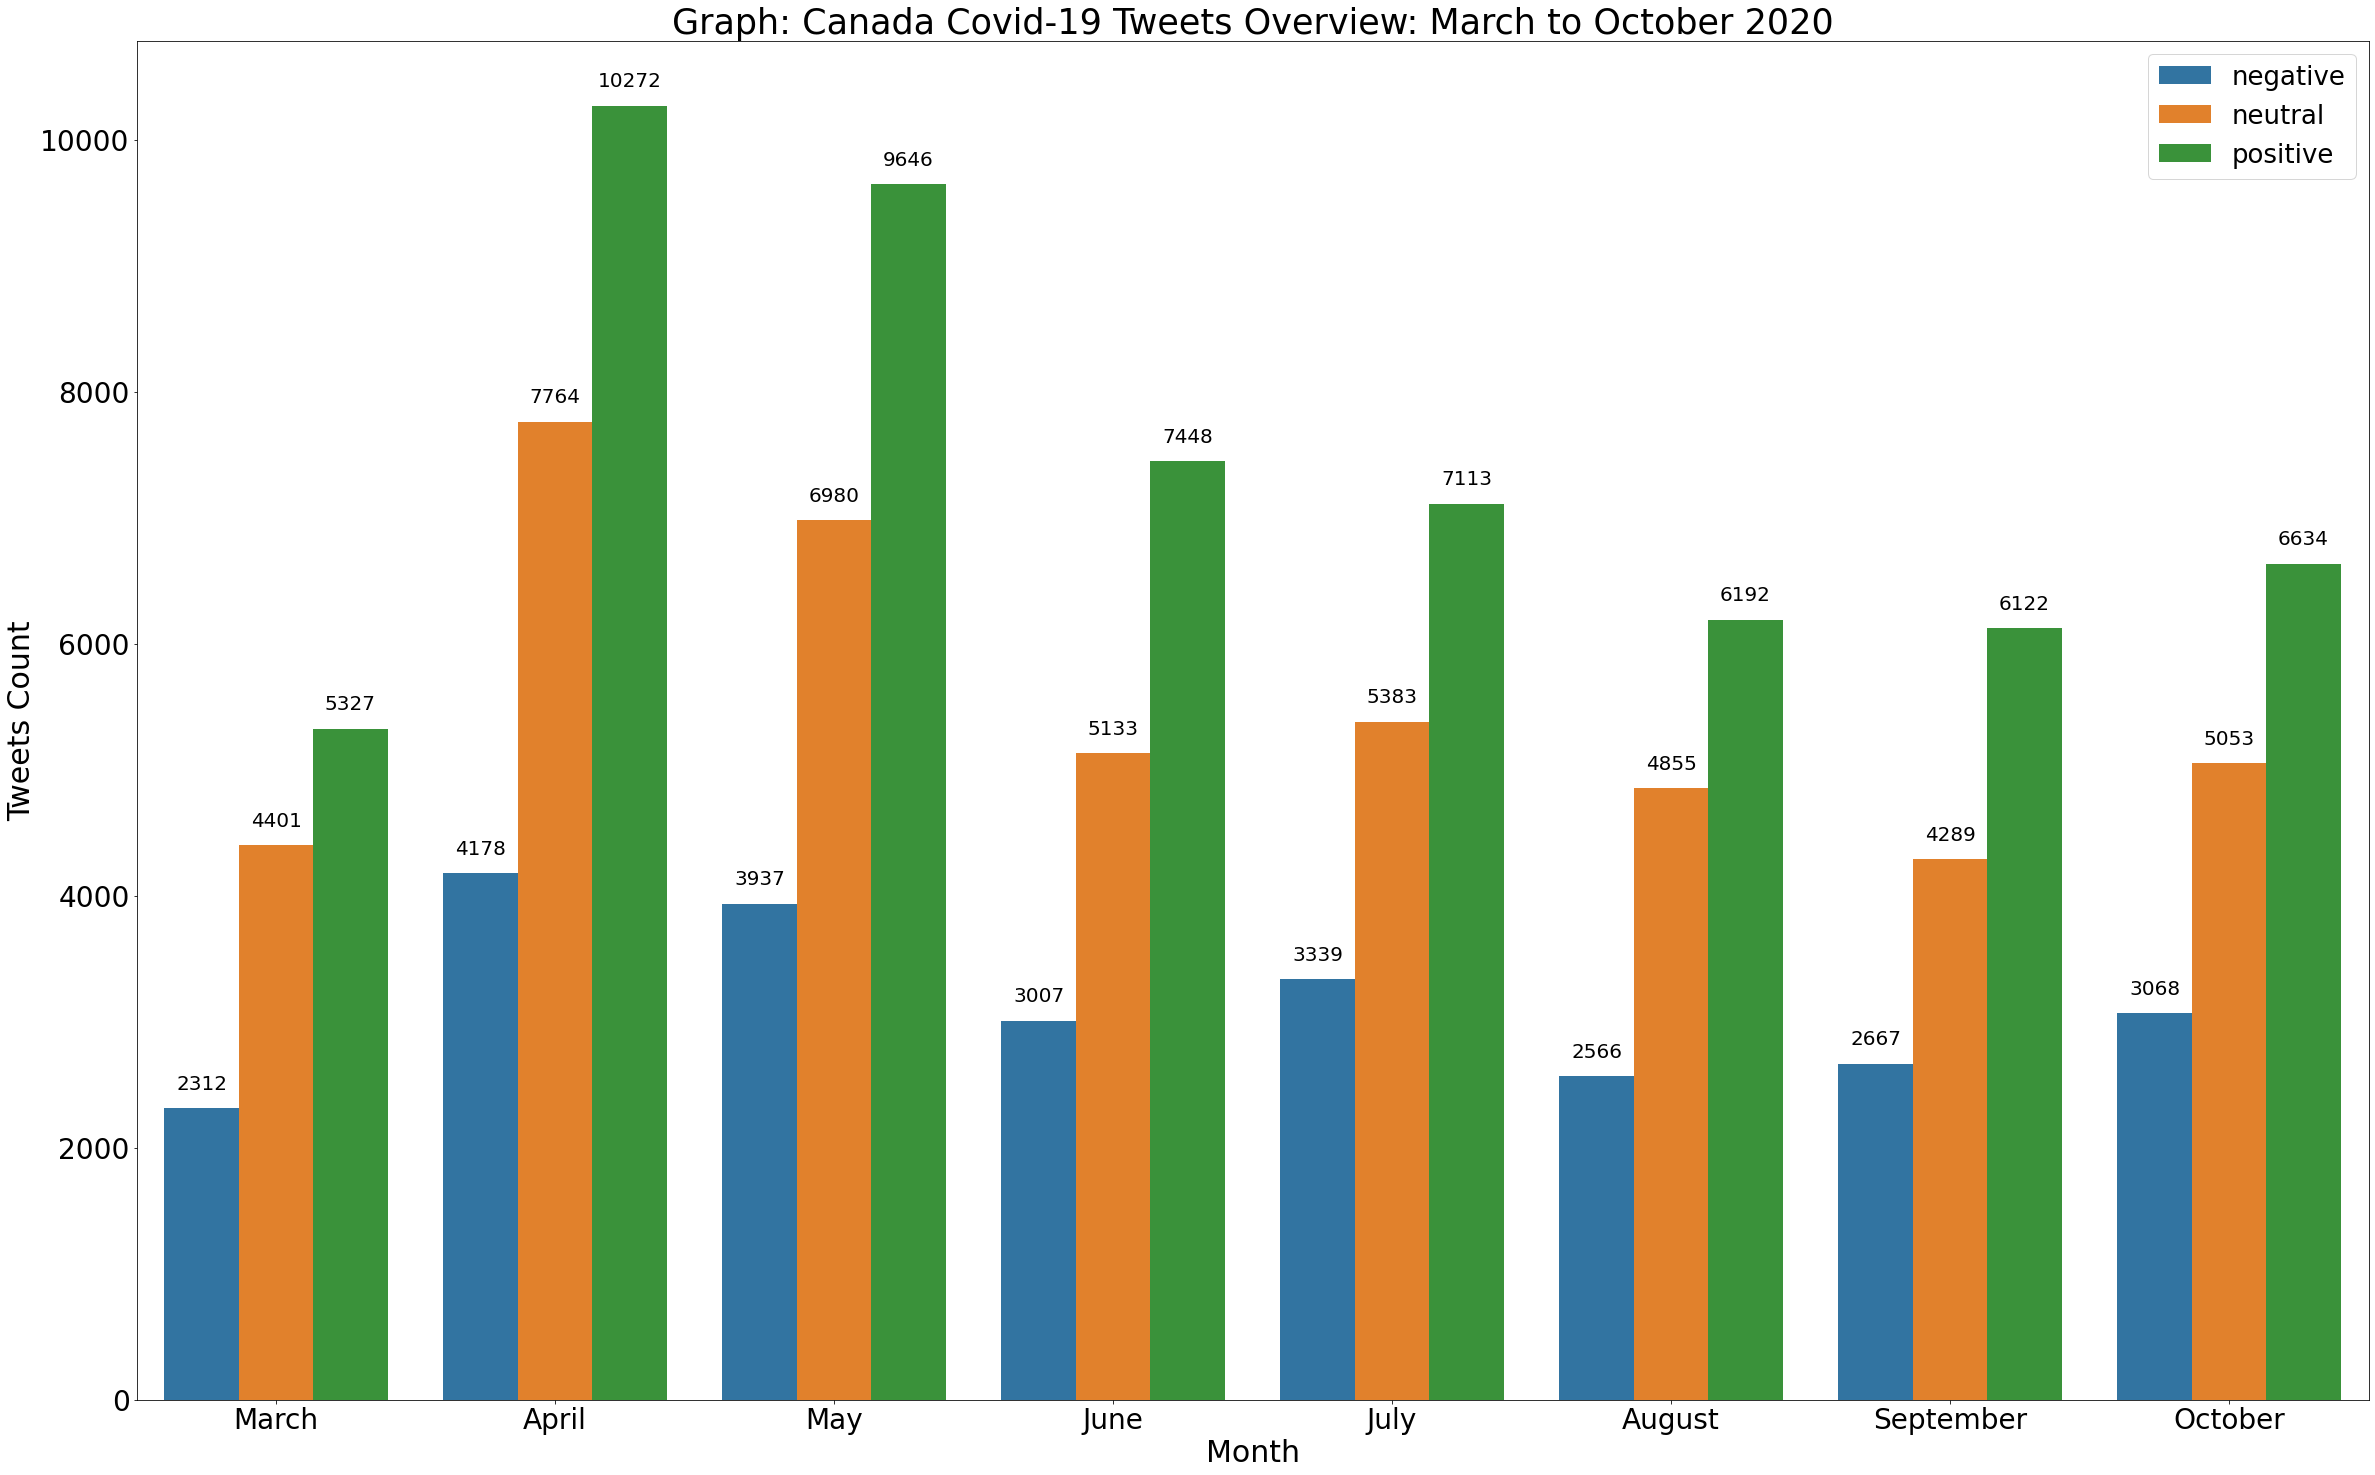

In [ ]:
#Plot each month's sentiment category for comparison purpose 

plt.figure(figsize=(40,25))
ax = sns.countplot(x='month',hue='textblob_label',data=canada_full)
total = float(len(canada_full))
for p in ax.patches:
        #percentage1= '{:.3f}%'.format(100 * p.get_height()/total)
        percentage = p.get_height()
        x = p.get_x() + p.get_width()/2 
        y = p.get_y() + p.get_height()+150
        ax.annotate(percentage, (x, y), ha="center", fontsize = 20)  
plt.xticks(fontsize =28)
plt.legend(loc='upper right', prop={'size': 26})
plt.yticks(fontsize =28)
plt.xticks(fontsize =28)
plt.xlabel('Month', fontsize=30)
plt.ylabel('Tweets Count', fontsize=30)
plt.title('Graph: Canada Covid-19 Tweets Overview: March to October 2020', fontsize =35)

In [ ]:
#stats of label distribution
canada_groupby = canada_full.groupby('textblob_label').count()
total_sample = len(canada_full)
negative_number = canada_groupby['tweet'].values[0]
neutral_number = canada_groupby['tweet'].values[1]
positive_number = canada_groupby['tweet'].values[2]
negative_percentage = negative_number/total_sample
neutral_percentage = neutral_number/total_sample
positive_percentage = positive_number/total_sample

display(canada_groupby)
print('There are',negative_number, "negative samples, which takes",negative_percentage, 'of the total number of samples')
print('There are',neutral_number, "neutral samples, which takes",neutral_percentage, 'of the total number of samples')
print('There are',positive_number, "positive samples, which takes",positive_percentage, 'of the total number of samples')




,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,25074,25074,25074,25074,25074,22802,25074,25074
neutral,43858,43858,43858,43858,43858,39805,43858,43858
positive,58754,58754,58754,58754,58754,54220,58754,58754


There are 25074 negative samples, which takes 0.19637235092335886 of the total number of samples
There are 43858 neutral samples, which takes 0.3434832323042464 of the total number of samples
There are 58754 positive samples, which takes 0.46014441677239476 of the total number of samples


In [ ]:
# create new dataframe only contain negative and positive category

canada_negative =canada_full.loc[(canada_full['textblob_label']=='negative'),:] 
canada_positive =canada_full.loc[(canada_full['textblob_label']=='positive'),:] 
canada_negative_and_positive = pd.concat([canada_negative,canada_positive],ignore_index =True)

print(len(canada_negative))
print(len(canada_positive))
print(len(canada_negative_and_positive))


25074
58754
83828


Text(0.5, 1.0, 'Graph: Canada Covid-19 Positive & Negative Tweets Overview: March to October 2020')

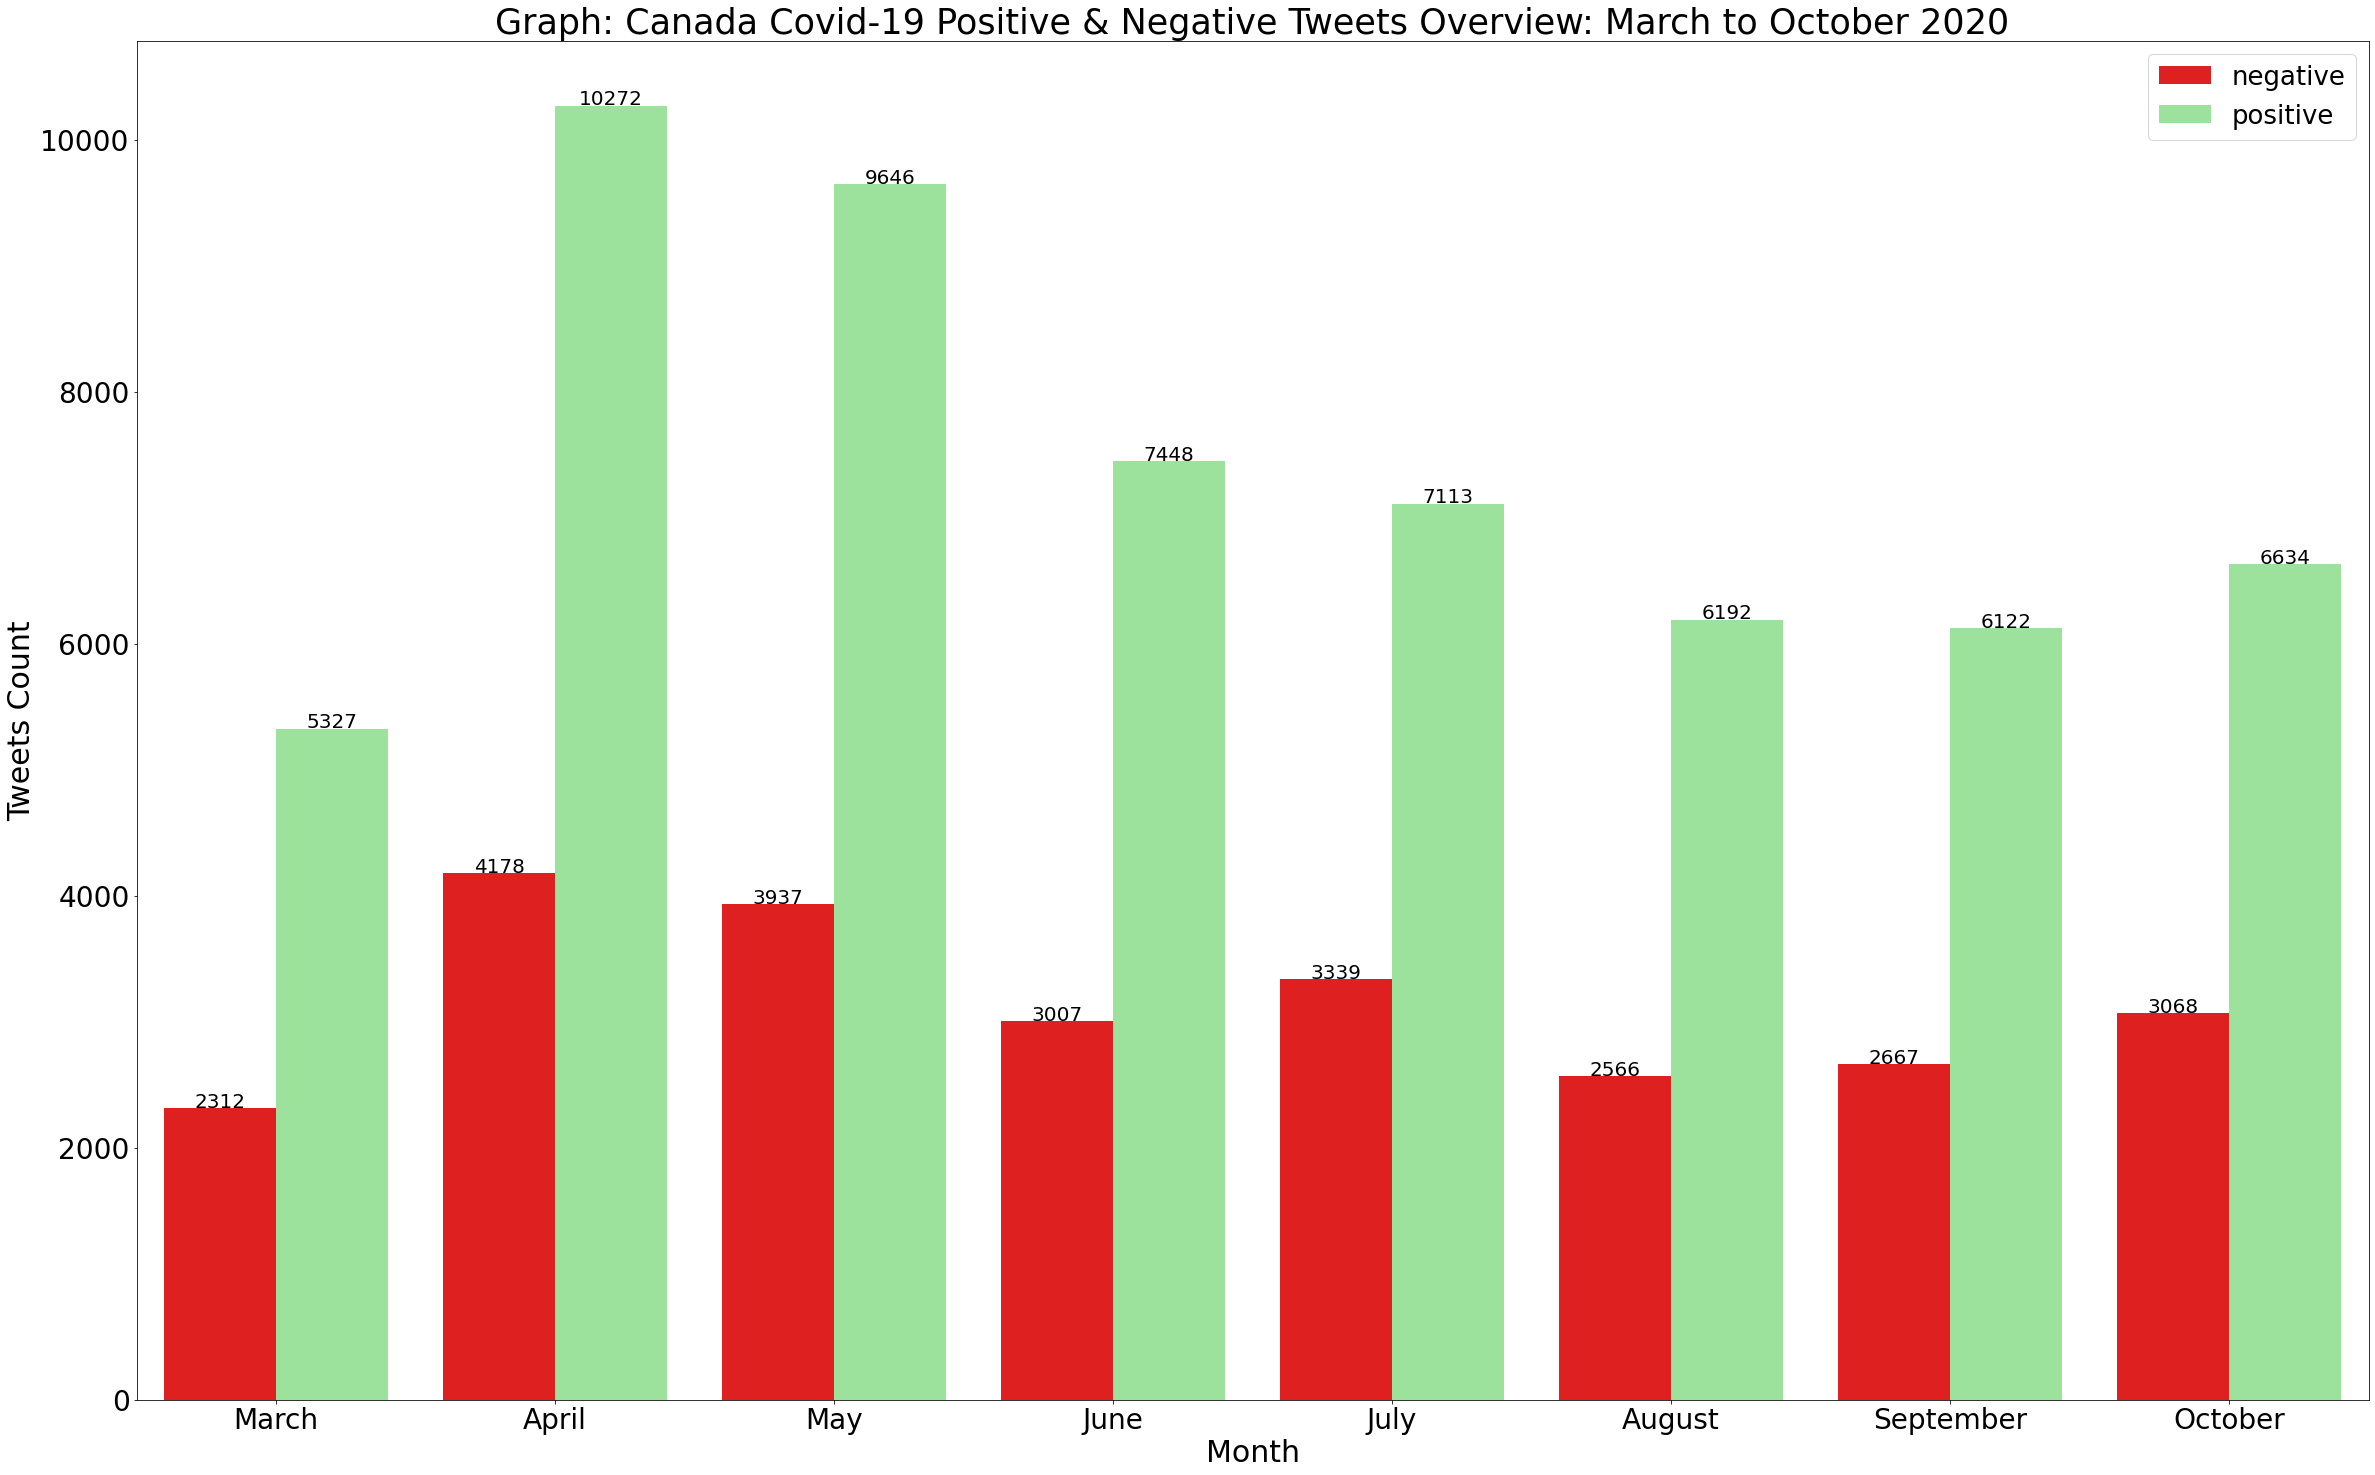

In [ ]:
## Only plot negative and positive categories to get more intuitive result

plt.figure(figsize=(40,25))
ax = sns.countplot(x='month',hue='textblob_label',data=canada_negative_and_positive, palette=['red', 'lightgreen'])
total = float(len(canada_negative_and_positive))
for p in ax.patches:
        #percentage1= '{:.3f}%'.format(100 * p.get_height()/total)
        percentage = p.get_height()
        x = p.get_x() + p.get_width()/2 
        y = p.get_y() + p.get_height()+5
        ax.annotate(percentage, (x, y), ha="center", fontsize = 20)  
plt.xticks(fontsize =28)
plt.legend(loc='upper right', prop={'size': 26})
plt.yticks(fontsize =28)
plt.xticks(fontsize =28)
plt.xlabel('Month', fontsize=30)
plt.ylabel('Tweets Count', fontsize=30)
plt.title('Graph: Canada Covid-19 Positive & Negative Tweets Overview: March to October 2020', fontsize =35)

date  tweet  ...  location  month
month_number textblob_label                ...                 
03           negative        2312   2312   ...  2105      2312 
             positive        5327   5327   ...  4906      5327 
04           negative        4178   4178   ...  3819      4178 
             positive        10272  10272  ...  9478      10272
05           negative        3937   3937   ...  3591      3937 
             positive        9646   9646   ...  8912      9646 
06           negative        3007   3007   ...  2776      3007 
             positive        7448   7448   ...  6938      7448 
07           negative        3339   3339   ...  3044      3339 
             positive        7113   7113   ...  6596      7113 
08           negative        2566   2566   ...  2329      2566 
             positive        6192   6192   ...  5668      6192 
09           negative        2667   2667   ...  2358      2667 
             positive        6122   6122   ...  5619      6122 
10           negative        3068   3068   ...  2780      3068 
             positive        6634   6634   ...  6103      6634 

[16 rows x 7 columns]

Text(0.5, 1.0, 'Graph: Canada Covid-19 Positive & Negative Tweets Volumn Change Over Time')

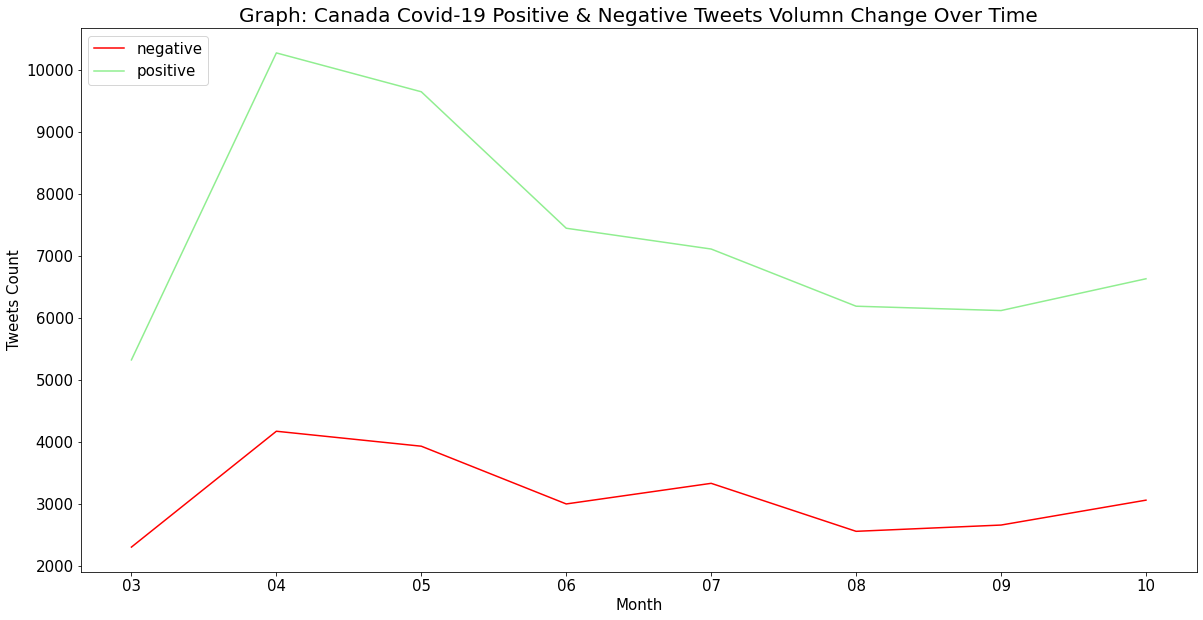

In [ ]:
#Create a pivot table for negative and positive category for each month
# and plot a line graph to understand the trend

a = canada_negative_and_positive.groupby(['month_number','textblob_label']).count()
display(a)
plt.figure(figsize=(20,10))

sns.lineplot(x="month_number", y="date", hue='textblob_label', data=a, palette=['red', 'lightgreen'])
plt.xticks(fontsize =28)
plt.legend(loc='upper left', prop={'size': 15})
plt.yticks(fontsize =15)
plt.xticks(fontsize =15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Tweets Count', fontsize=15)
plt.title('Graph: Canada Covid-19 Positive & Negative Tweets Volumn Change Over Time', fontsize =20)

# Print some sample Tweets

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)


print(canada_full['tweet'][5:100])
# print(canada_full['tweet'][55])
# print(canada_full['tweet'][555])
# print(canada_full['tweet'][5555])
# print(canada_full['tweet'][55555])
# print(canada_full['tweet'][10])
# print(canada_full['tweet'][15])
# print(canada_full['tweet'][20])
# print(canada_full['tweet'][66])
# print(canada_full['tweet'][77])
# print(canada_full['tweet'][88])


5     'Trump criticized after making careless comments aout the coronavirus on Fox News via '                                                                                                                                                                                      
6     "Women's hockey championship cancelled over coronavirus concerns "                                                                                                                                                                                                           
7     '. helps develop to assist with '                                                                                                                                                                                                                                            
8     ' Have em. Only lives once. Could e dead from coronavirus next month.....'                                                                                            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# Preprocess Tweets


In [ ]:
# test

df_test = canada_full.copy()
df_test["new_column"] = df_test['tweet'].str.replace('[^\w\s]','')
df_test["new_column"]  = df_test["new_column"].str.lower()
df_test

,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number,new_column
0,Thu Mar 05 20:23:47 +0000 2020,'The audience sumitted their unanswered questions and I spoke with to get some answers. ',"[0.0, 1.0, 0.0, 0.0]",neutral,-0.100000,negative,"Toronto, Ontario",March,03,the audience sumitted their unanswered questions and i spoke with to get some answers
1,Fri Mar 06 07:20:09 +0000 2020,'Workplace vs. Coronavirus: No One Has a Playook for This ',"[0.18, 0.82, 0.0, -0.296]",neutral,0.000000,neutral,Vancouver,March,03,workplace vs coronavirus no one has a playook for this
2,Fri Mar 06 23:16:32 +0000 2020,"' All I know is,that in the US, Hillary Clinton is responsile for more deaths than the Corona virus.'","[0.0, 1.0, 0.0, 0.0]",neutral,0.500000,positive,"Burford, Ontario",March,03,all i know isthat in the us hillary clinton is responsile for more deaths than the corona virus
3,Sat Mar 07 11:45:47 +0000 2020,"'Are we surrrrre the coronavirus wasnt started y the toilet paper companies? What am I missing here? WHY THE TOILET PAPER, PEOPLE?! WHY? '","[0.131, 0.869, 0.0, -0.5349]",neutral,-0.091667,negative,Canada,March,03,are we surrrrre the coronavirus wasnt started y the toilet paper companies what am i missing here why the toilet paper people why
4,Sat Mar 07 13:34:20 +0000 2020,'I would like to speak to the CEO or Corona virus ',"[0.0, 0.815, 0.185, 0.3612]",neutral,0.000000,neutral,NaN,March,03,i would like to speak to the ceo or corona virus
...,...,...,...,...,...,...,...,...,...,...
127681,Sat Oct 31 23:53:20 +0000 2020,'Science. ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"British Columbia, Canada",October,10,science
127682,Sat Oct 31 23:43:58 +0000 2020,'Dont e too quick to praise Trudeaus slow response to COVID19 ',"[0.0, 0.753, 0.247, 0.5574]",neutral,0.016667,positive,"Perth, Ontario",October,10,dont e too quick to praise trudeaus slow response to covid19
127683,Sat Oct 31 23:33:29 +0000 2020,'We live in weird times. We can thank Covid19',"[0.152, 0.625, 0.223, 0.2023]",neutral,-0.181818,negative,NaN,October,10,we live in weird times we can thank covid19
127684,Sat Oct 31 23:51:32 +0000 2020,'\x8spread love not the virus ',"[0.0, 0.543, 0.457, 0.6369]",neutral,0.500000,positive,"Montréal, Québec",October,10,x8spread love not the virus


In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)


print(df_test['new_column'][5:100])

5     trump criticized after making careless comments aout the coronavirus on fox news via                                                                                                                                                                                    
6     womens hockey championship cancelled over coronavirus concerns                                                                                                                                                                                                          
7      helps develop to assist with                                                                                                                                                                                                                                           
8      have em only lives once could e dead from coronavirus next month                                                                                                                    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# decide to use this preprocessing helper function to process tweets

In [ ]:
import re

def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)

    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text

In [ ]:
preprocessed = [preprocess(message) for message in tqdm(df_test['new_column'])]


In [ ]:
# check processed tweets samples

preprocessed[0:20]

['the audience sumitted their unanswered questions and spoke with to get some answers',
 'workplace vs coronavirus no one has playook for this',
 'all know isthat in the us hillary clinton is responsile for more deaths than the corona virus',
 'are we surrrrre the coronavirus wasnt started the toilet paper companies what am missing here why the toilet paper people why',
 'would like to speak to the ceo or corona virus',
 'trump criticized after making careless comments aout the coronavirus on fox news via',
 'womens hockey championship cancelled over coronavirus concerns',
 'helps develop to assist with',
 'have em only lives once could dead from coronavirus next month',
 'trump youre standing next to dr and lieing aout coronavirus wtf',
 'bbc news coronavirus lancaster catholic diocese ans hymn ooks from communal chalice is gross even in the est of times',
 'if tells you that the pandemic is under control and if he says this while he is playing his imaginary accordion he is lying',
 '

# Tokenize txt 
we use NLTK library with lemmatization and stopword removal. 

In [ ]:
#helper function

from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option):
  '''
  Tokenize the input text as per specified option
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return text.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
  elif option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    logger.warn("Please specify option value between 1 and 4")
    return []

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# <font color='violet'>3. Canada Most frequent terms Analysis</font> 
## Creat word cloud 
## Plot bar graph for top 80 most frequent terms 


[2020-11-12 22:41:52,585][INFO] ## The number of all words: 1540476
[2020-11-12 22:41:52,804][INFO] ## The number of unique words: 64222
[2020-11-12 22:41:52,828][INFO] ## Top 40 frequent words: ['covid', 'coronavirus', 'amp', 'people', 'case', 'health', 'get', 'stigma', 'say', 'new', 'fight', 'aout', 'go', 'ut', 'test', 'u', 'time', 'need', 'pandemic', 'one', 'day', 'like', 'make', 'work', 'een', 'ireland', 'death', 'take', 'canada', 'mask', 'thank', 'see', 'today', 'dont', 'know', 'think', 'help', 'trump', 'home', 'good']


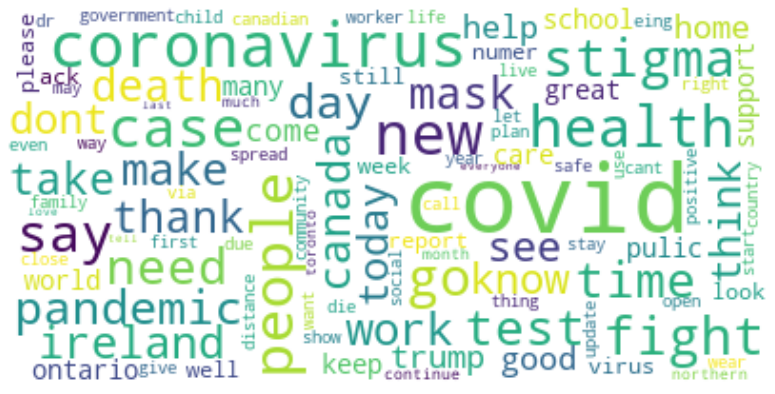

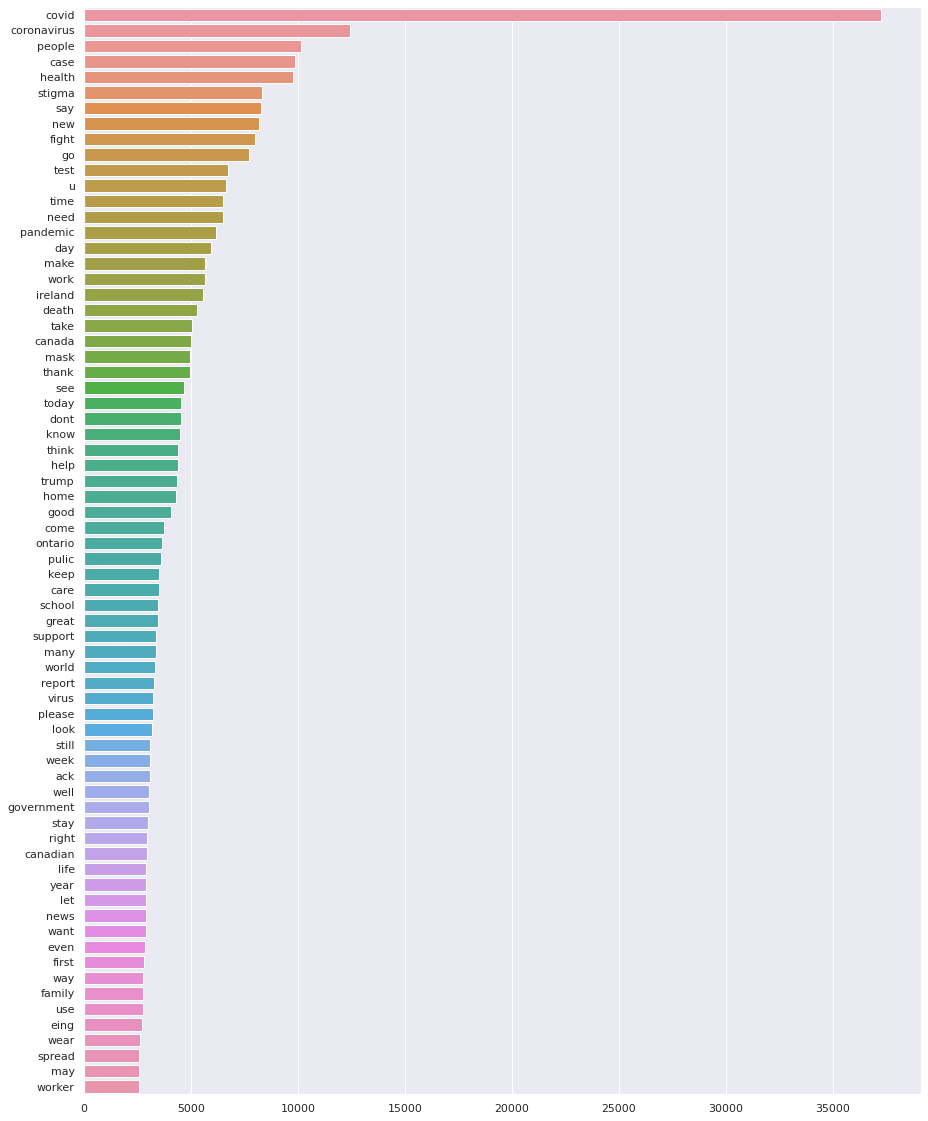

In [ ]:
# tokenize tweet, creat vocab

# Create vocab
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 4) # Use option 3
        corpus.extend(tokens)
    logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["I", "e", "the", "amp", "will", "y",'aout','ut','een','A','The','This','one','rt','ecause','im'])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(15,20))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab

vocab= create_vocab(preprocessed, True)

## Create token id list
#token_ids = [[vocab[word] for word in text_words] for text_words in tokenized] # comment out to save memory


# <font color='orange'>4. Canada Random Baseline</font> 
Establish a random baseline: randomly assign label to each tweet.
From mathematic perspective, if our model can beat the random score basline, it means our model is making an impact. 

In [ ]:
canada_baseline = canada_full.copy()
canada_baseline

,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number
0,Thu Mar 05 20:23:47 +0000 2020,'The audience sumitted their unanswered questi...,"[0.0, 1.0, 0.0, 0.0]",neutral,-0.100000,negative,"Toronto, Ontario",March,03
1,Fri Mar 06 07:20:09 +0000 2020,'Workplace vs. Coronavirus: No One Has a Playo...,"[0.18, 0.82, 0.0, -0.296]",neutral,0.000000,neutral,Vancouver,March,03
2,Fri Mar 06 23:16:32 +0000 2020,"' All I know is,that in the US, Hillary Clinto...","[0.0, 1.0, 0.0, 0.0]",neutral,0.500000,positive,"Burford, Ontario",March,03
3,Sat Mar 07 11:45:47 +0000 2020,'Are we surrrrre the coronavirus wasnt started...,"[0.131, 0.869, 0.0, -0.5349]",neutral,-0.091667,negative,Canada,March,03
4,Sat Mar 07 13:34:20 +0000 2020,'I would like to speak to the CEO or Corona vi...,"[0.0, 0.815, 0.185, 0.3612]",neutral,0.000000,neutral,NaN,March,03
...,...,...,...,...,...,...,...,...,...
127681,Sat Oct 31 23:53:20 +0000 2020,'Science. ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"British Columbia, Canada",October,10
127682,Sat Oct 31 23:43:58 +0000 2020,'Dont e too quick to praise Trudeaus slow resp...,"[0.0, 0.753, 0.247, 0.5574]",neutral,0.016667,positive,"Perth, Ontario",October,10
127683,Sat Oct 31 23:33:29 +0000 2020,'We live in weird times. We can thank Covid19',"[0.152, 0.625, 0.223, 0.2023]",neutral,-0.181818,negative,NaN,October,10
127684,Sat Oct 31 23:51:32 +0000 2020,'\x8spread love not the virus ',"[0.0, 0.543, 0.457, 0.6369]",neutral,0.500000,positive,"Montréal, Québec",October,10


In [ ]:
# assign number to textblob_label, positive: 2, neutral: 1, negative: 0 for classification purpose
canada_baseline['number_textblob_label'] = canada_baseline['textblob_label'].replace(to_replace=["positive",'neutral','negative'],value=[int(2),int(1),int(0)])
canada_baseline



,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number,number_textblob_label,random_score
0,Thu Mar 05 20:23:47 +0000 2020,'The audience sumitted their unanswered questi...,"[0.0, 1.0, 0.0, 0.0]",neutral,-0.100000,negative,"Toronto, Ontario",March,03,0,0
1,Fri Mar 06 07:20:09 +0000 2020,'Workplace vs. Coronavirus: No One Has a Playo...,"[0.18, 0.82, 0.0, -0.296]",neutral,0.000000,neutral,Vancouver,March,03,1,1
2,Fri Mar 06 23:16:32 +0000 2020,"' All I know is,that in the US, Hillary Clinto...","[0.0, 1.0, 0.0, 0.0]",neutral,0.500000,positive,"Burford, Ontario",March,03,2,1
3,Sat Mar 07 11:45:47 +0000 2020,'Are we surrrrre the coronavirus wasnt started...,"[0.131, 0.869, 0.0, -0.5349]",neutral,-0.091667,negative,Canada,March,03,0,1
4,Sat Mar 07 13:34:20 +0000 2020,'I would like to speak to the CEO or Corona vi...,"[0.0, 0.815, 0.185, 0.3612]",neutral,0.000000,neutral,NaN,March,03,1,0
...,...,...,...,...,...,...,...,...,...,...,...
127681,Sat Oct 31 23:53:20 +0000 2020,'Science. ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"British Columbia, Canada",October,10,1,1
127682,Sat Oct 31 23:43:58 +0000 2020,'Dont e too quick to praise Trudeaus slow resp...,"[0.0, 0.753, 0.247, 0.5574]",neutral,0.016667,positive,"Perth, Ontario",October,10,2,0
127683,Sat Oct 31 23:33:29 +0000 2020,'We live in weird times. We can thank Covid19',"[0.152, 0.625, 0.223, 0.2023]",neutral,-0.181818,negative,NaN,October,10,0,0
127684,Sat Oct 31 23:51:32 +0000 2020,'\x8spread love not the virus ',"[0.0, 0.543, 0.457, 0.6369]",neutral,0.500000,positive,"Montréal, Québec",October,10,2,1


In [ ]:
#create a random baseline, assign randomly to each tweet with score from int (0,1,2)
canada_baseline['random_score'] = np.random.randint(0, 3, len(canada_baseline))
canada_baseline


,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number,number_textblob_label,random_score
0,Thu Mar 05 20:23:47 +0000 2020,'The audience sumitted their unanswered questi...,"[0.0, 1.0, 0.0, 0.0]",neutral,-0.100000,negative,"Toronto, Ontario",March,03,0,2
1,Fri Mar 06 07:20:09 +0000 2020,'Workplace vs. Coronavirus: No One Has a Playo...,"[0.18, 0.82, 0.0, -0.296]",neutral,0.000000,neutral,Vancouver,March,03,1,1
2,Fri Mar 06 23:16:32 +0000 2020,"' All I know is,that in the US, Hillary Clinto...","[0.0, 1.0, 0.0, 0.0]",neutral,0.500000,positive,"Burford, Ontario",March,03,2,2
3,Sat Mar 07 11:45:47 +0000 2020,'Are we surrrrre the coronavirus wasnt started...,"[0.131, 0.869, 0.0, -0.5349]",neutral,-0.091667,negative,Canada,March,03,0,1
4,Sat Mar 07 13:34:20 +0000 2020,'I would like to speak to the CEO or Corona vi...,"[0.0, 0.815, 0.185, 0.3612]",neutral,0.000000,neutral,NaN,March,03,1,2
...,...,...,...,...,...,...,...,...,...,...,...
127681,Sat Oct 31 23:53:20 +0000 2020,'Science. ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"British Columbia, Canada",October,10,1,0
127682,Sat Oct 31 23:43:58 +0000 2020,'Dont e too quick to praise Trudeaus slow resp...,"[0.0, 0.753, 0.247, 0.5574]",neutral,0.016667,positive,"Perth, Ontario",October,10,2,2
127683,Sat Oct 31 23:33:29 +0000 2020,'We live in weird times. We can thank Covid19',"[0.152, 0.625, 0.223, 0.2023]",neutral,-0.181818,negative,NaN,October,10,0,2
127684,Sat Oct 31 23:51:32 +0000 2020,'\x8spread love not the virus ',"[0.0, 0.543, 0.457, 0.6369]",neutral,0.500000,positive,"Montréal, Québec",October,10,2,1


In [ ]:
print(canada_baseline['random_score'].nunique())

3


Random Baseline Classifier report 
               precision    recall  f1-score   support

           0       0.20      0.33      0.25     25074
           1       0.34      0.33      0.34     43858
           2       0.46      0.33      0.39     58754

    accuracy                           0.33    127686
   macro avg       0.33      0.33      0.32    127686
weighted avg       0.37      0.33      0.34    127686



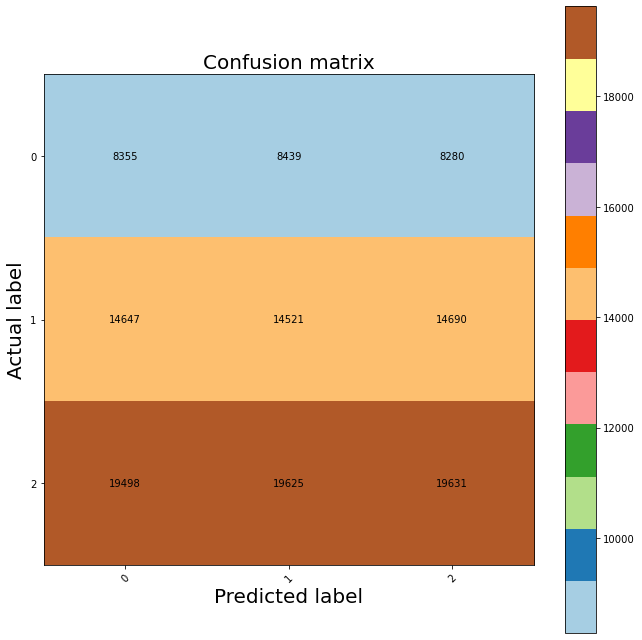

In [ ]:
# random baseline confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


print("Canada Random Baseline Classifier report \n", classification_report(canada_baseline['number_textblob_label'], canada_baseline['random_score']))

# confusion matrix
plt.figure(figsize=(9,9))

dree_cm=confusion_matrix(canada_baseline['number_textblob_label'], canada_baseline['random_score'])

#cmap name: terrain, ocean,Accent,Paired
plt.imshow(dree_cm, interpolation='nearest', cmap='Paired')
plt.title('Confusion matrix', size = 20)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["0", "1", "2"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0", "1", "2"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 20)
plt.xlabel('Predicted label', size = 20)
width, height = dree_cm.shape
for x in range(width):
     for y in range(height):
              plt.annotate(str(dree_cm[x][y]), xy=(y, x), 
              horizontalalignment='center',
              verticalalignment='center')

# <font color='blue'>5. Canada Bert Model classification</font> 


# Process Data for Bert Model
## assign label with different number: 
positive 2
neutral 1
negative 0

In [ ]:
df_test['number_textblob_label'] = df_test['textblob_label'].replace(to_replace=["positive",'neutral','negative'],value=[2,1,0])
df_test

,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number,new_column,number_textblob_label
0,Thu Mar 05 20:23:47 +0000 2020,'The audience sumitted their unanswered questions and I spoke with to get some answers. ',"[0.0, 1.0, 0.0, 0.0]",neutral,-0.100000,negative,"Toronto, Ontario",March,03,the audience sumitted their unanswered questions and i spoke with to get some answers,0
1,Fri Mar 06 07:20:09 +0000 2020,'Workplace vs. Coronavirus: No One Has a Playook for This ',"[0.18, 0.82, 0.0, -0.296]",neutral,0.000000,neutral,Vancouver,March,03,workplace vs coronavirus no one has a playook for this,1
2,Fri Mar 06 23:16:32 +0000 2020,"' All I know is,that in the US, Hillary Clinton is responsile for more deaths than the Corona virus.'","[0.0, 1.0, 0.0, 0.0]",neutral,0.500000,positive,"Burford, Ontario",March,03,all i know isthat in the us hillary clinton is responsile for more deaths than the corona virus,2
3,Sat Mar 07 11:45:47 +0000 2020,"'Are we surrrrre the coronavirus wasnt started y the toilet paper companies? What am I missing here? WHY THE TOILET PAPER, PEOPLE?! WHY? '","[0.131, 0.869, 0.0, -0.5349]",neutral,-0.091667,negative,Canada,March,03,are we surrrrre the coronavirus wasnt started y the toilet paper companies what am i missing here why the toilet paper people why,0
4,Sat Mar 07 13:34:20 +0000 2020,'I would like to speak to the CEO or Corona virus ',"[0.0, 0.815, 0.185, 0.3612]",neutral,0.000000,neutral,NaN,March,03,i would like to speak to the ceo or corona virus,1
...,...,...,...,...,...,...,...,...,...,...,...
127681,Sat Oct 31 23:53:20 +0000 2020,'Science. ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"British Columbia, Canada",October,10,science,1
127682,Sat Oct 31 23:43:58 +0000 2020,'Dont e too quick to praise Trudeaus slow response to COVID19 ',"[0.0, 0.753, 0.247, 0.5574]",neutral,0.016667,positive,"Perth, Ontario",October,10,dont e too quick to praise trudeaus slow response to covid19,2
127683,Sat Oct 31 23:33:29 +0000 2020,'We live in weird times. We can thank Covid19',"[0.152, 0.625, 0.223, 0.2023]",neutral,-0.181818,negative,NaN,October,10,we live in weird times we can thank covid19,0
127684,Sat Oct 31 23:51:32 +0000 2020,'\x8spread love not the virus ',"[0.0, 0.543, 0.457, 0.6369]",neutral,0.500000,positive,"Montréal, Québec",October,10,x8spread love not the virus,2


In [ ]:
# compare results

sentiments = df_test['number_textblob_label']
messages = df_test['new_column']
tmp_dict = {'org message': messages, 'sentence': preprocessed, 'label': sentiments}
tmp_df = pd.DataFrame(tmp_dict).sample(n=20, random_state=rand_seed)

# Samples
pd.set_option('display.max_colwidth', 200)
tmp_df

,org message,sentence,label
91538,heard on we are investing a total of 450 million in the production of vaccines ceo of if the vaccine candidate does not work they will take a hit of 100 million vaccines are eing split 50 etween ...,heard on we are investing total of million in the production of vaccines ceo of if the vaccine candidate does not work they will take hit of million vaccines are eing split etween india and world,1
97193,when times get tough canadians get things done like in north a canadian manufacturer usually making auto parts ut now retooled to produce highquality medical face masks through our governments to...,when times get tough canadians get things done like in north canadian manufacturer usually making auto parts ut now retooled to produce highquality medical face masks through our governments to fight,0
127194,nalerta has set a new record for active covid19 casesdue to weekend nonreporting amp server maintenance monday we wont get another data update until tuesday at 30 pmxx8server maintenance on monday,nalerta has set new record for active covid casesdue to weekend nonreporting amp server maintenance monday we wont get another data update until tuesday at pmxx server maintenance on monday,2
60458,disgusting those payments are how vulnerale people survive why is this creep still talking he lost the election for a reason,disgusting those payments are how vulnerale people survive why is this creep still talking he lost the election for reason,0
114722,this is ridiculous hire more people to do contact tracing its too important if there is a acklog,this is ridiculous hire more people to do contact tracing its too important if there is acklog,2
95577,does it make me a terrile person for hoping it is not my class that ends up with test positive case and i end up on the news and skewered y social media i ask ecause that would mean i am essential...,does it make me terrile person for hoping it is not my class that ends up with test positive case and end up on the news and skewered social media ask ecause that would mean am essentially wishing...,0
92522,rs l cr needed to complete stalled india projects new delhi with the covid19 pandemic ringing the alreadystressed real estate sector to a grinding halt the president of naredco niranjan hiranandan...,rs cr needed to complete stalled india projects new delhi with the covid pandemic ringing the alreadystressed real estate sector to grinding halt the president of naredco niranjan hiranandani has ...,2
15113,i am for and for ut i cannot support ecause i dont use credit and and need a credit card to pay i prefer interac,am for and for ut cannot support ecause dont use credit and and need credit card to pay prefer interac,1
117035,penis loosing it,penis loosing it,1
44034,well thats definitely a good thing the respectful flirting it im glad i got married yrs ago cuz id have no idea how to go aout it nowadays even without covid19 going on hey how are 6ft,well thats definitely good thing the respectful flirting it im glad got married yrs ago cuz id have no idea how to go aout it nowadays even without covid going on hey how are ft,2


# Canada Training data stats overview


[2020-11-12 22:53:49,070][INFO] ## The total number of input data: 101210


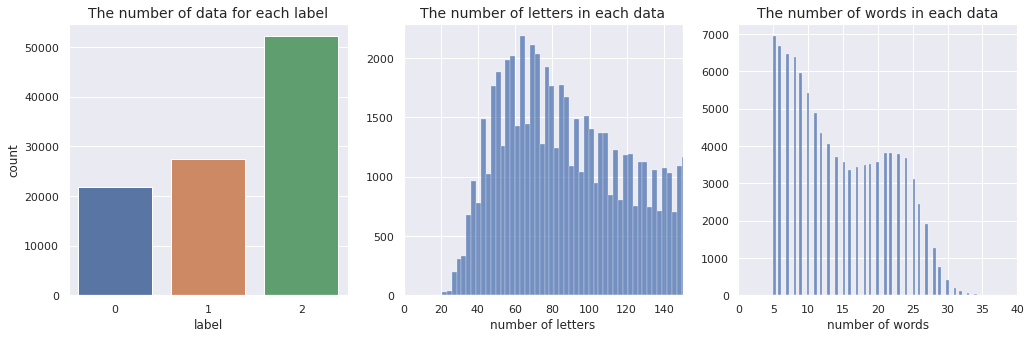

In [ ]:
# Create a dataframe for training data
word_cnt = [len(tokenize_text(x, 4)) for x in tqdm(preprocessed)]
messages = df_test['new_column']
sentiments = df_test['number_textblob_label']

# Use tweets having 5 or more words. Do not resample for balancing data here.
train_dict = {'text': preprocessed, 'label': sentiments, 'count': word_cnt}
train_df = pd.DataFrame(train_dict)
train_df = train_df.loc[train_df['count'] >= 5]
train_df.reset_index(drop=True, inplace=True)
logger.info("The total number of input data: {}".format(len(train_df)))

# Display the distribution graph
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(17,5))
sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data for each label', fontsize=14)
sns.histplot([len(x) for x in train_df['text']], ax=ax2, bins=100)
ax2.set_title('The number of letters in each data', fontsize=14)
ax2.set_xlim(0,150)
ax2.set_xlabel('number of letters')
ax2.set_ylabel("")
sns.histplot(train_df['count'], ax=ax3, bins=100)
ax3.set_title('The number of words in each data', fontsize=14)
ax3.set_xlim(0,40)
ax3.set_xlabel('number of words')
ax3.set_ylabel("")

plt.show()

# BERT Model Training

In [ ]:
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset

from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

# Pytorch Dataset
helper function: create a dataset class and data loader for pytroch

In [ ]:
# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return self.datalist[idx]
  

# Data Loader
def create_data_loader(X, y, indices, batch_size, shuffle):
    X_sampled = np.array(X, dtype=object)[indices]
    y_sampled = np.array(y)[indices].astype(int)
    dataset = SimpleDataset(X_sampled, y_sampled)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

# Training code
The code is a combination of transformer and existing BERT implementation from GitHub

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_cycles(X_all, y_all, vocab, num_samples, model_type, epochs, patience, batch_size, seq_len, lr, clip, log_level):
    result = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time', 'ms/text'], index=num_samples)

    for n in num_samples:
        print("")
        logger.info("############### Start training for %d samples ###############" %n)

        # Stratified sampling
        train_size = n / len(y_all)
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=train_size*0.2 , random_state=rand_seed)
        train_indices, valid_indices = next(sss.split(X_all, y_all))

        # Sample input data
        train_loader = create_data_loader(X_all, y_all, train_indices, batch_size, True)
        valid_loader = create_data_loader(X_all, y_all, valid_indices, batch_size, False)

        if model_type == 'LSTM':
            model = TextClassifier(len(vocab)+1, embed_size=512, lstm_size=1289, dense_size=0, output_size=5, lstm_layers=4, dropout=0.2)
            model.embedding.weight.data.uniform_(-1, 1)
        elif model_type == 'BERT':
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

        start_time = time.perf_counter() # use time.process_time() for CPU time
        acc, f1, model_trained = train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level)
        end_time = time.perf_counter() # use time.process_time() for CPU time
        duration = end_time - start_time
        logger.info("Process Time (sec): {}".format(duration))
        result.loc[n] = (round(acc,4), round(f1,4), duration, duration/n*1000)

    return result, model_trained

In [ ]:
def train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level):
    # Set variables
    logger = set_logger('sa_tweet_inperf', log_level)
    num_total_opt_steps = int(len(train_loader) * epochs)
    eval_every = len(train_loader) // 5
    warm_up_proportion = 0.1
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), epochs))

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW_HF(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler
    criterion = nn.NLLLoss()

    # Set Train Mode
    model.train()

    # Initialise
    acc_train, f1_train, loss_train, acc_valid, f1_valid, loss_valid = [], [], [], [], [], []
    best_f1, early_stop, steps = 0, 0, 0
    class_names = ['0:Negative','1:Neutral', '2:Positive']

    for epoch in tqdm(range(epochs), desc="Epoch"):
        logger.info('================     epoch {}     ==============='.format(epoch+1))

        #################### Training ####################
        # Initialise
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []
        hidden = model.init_hidden(batch_size) if model_type == "LSTM" else None

        for i, batch in enumerate(train_loader):
            text_batch, labels = batch
            # Skip the last batch of which size is not equal to batch_size
            if labels.size(0) != batch_size:
                break
            steps += 1
           
            # Reset gradient
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % eval_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            if model_type == "LSTM":
                # Tokenize the input and move to device
                text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Creating new variables for the hidden state to avoid backprop entire training history
                hidden = tuple([each.data for each in hidden])
                for each in hidden:
                    each.to(device)

                # Get output and hidden state from the model, calculate the loss
                logits, hidden = model(text_batch, hidden)
                loss = criterion(logits, labels)
                
            elif model_type == 'BERT':
                # Tokenize the input and move to device
                # Tokenizer Parameter
                param_tk = {
                    'return_tensors': "pt",
                    'padding': 'max_length',
                    'max_length': seq_len,
                    'add_special_tokens': True,
                    'truncation': True
                }
                text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Feedforward prediction
                loss, logits = model(**text_batch, labels=labels)

            y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
            y_truth_tmp.extend(labels.cpu().numpy())

            # Back prop
            loss.backward()

            # Training Loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()


            #################### Evaluation ####################
            if (steps % eval_every == 0) or ((steps % eval_every != 0) and (steps == len(train_loader))):
                # Evaluate Training
                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # y_pred_tmp = np.zeros((len(y_valid), 5))
                y_truth_tmp, y_pred_tmp = [], []

                # Move to Evaluation Mode
                model.eval()

                with torch.no_grad():
                    for i, batch in enumerate(valid_loader):
                        text_batch, labels = batch
                        # Skip the last batch of which size is not equal to batch_size
                        if labels.size(0) != batch_size:
                            break

                        if model_type == "LSTM":
                            # Tokenize the input and move to device
                            text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)

                            # Creating new variables for the hidden state to avoid backprop entire training history
                            hidden = tuple([each.data for each in hidden])
                            for each in hidden:
                                each.to(device)

                            # Get output and hidden state from the model, calculate the loss
                            logits, hidden = model(text_batch, hidden)
                            loss = criterion(logits, labels)
                
                        elif model_type == 'BERT':
                            # Tokenize the input and move to device
                            text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)
                            # Feedforward prediction
                            loss, logits = model(**text_batch, labels=labels)
                    
                        loss_tmp += loss.item()
                        loss_cnt += 1

                        y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
                        y_truth_tmp.extend(labels.cpu().numpy())
                        # logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))

                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                logger.debug("Epoch: {}/{}, Step: {}, Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}".format(epoch+1, epochs, steps, loss_tmp, acc, f1))
                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Back to train mode
                model.train()

        #################### End of each epoch ####################

        # Show the last evaluation metrics
        logger.info('Epoch: %d, Loss: %.4f, Acc: %.4f, F1: %.4f, LR: %.2e' % (epoch+1, loss_valid[-1], acc_valid[-1], f1_valid[-1], scheduler.get_last_lr()[0]))

        # Plot Confusion Matrix
        y_truth_class = [class_names[int(idx)] for idx in y_truth_tmp]
        y_predicted_class = [class_names[int(idx)] for idx in y_pred_tmp]
        
        titles_options = [("Actual Count", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=75)
        plt.show()

        # plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, 'b-o', label='Train Loss')
        ax1.plot(loss_valid, 'r-o', label='Valid Loss')
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(acc_train, 'y-o', label='Accuracy (train)')
        ax2.plot(f1_train, 'y--', label='F1 Score (train)')
        ax2.plot(acc_valid, 'g-o', label='Accuracy (valid)')
        ax2.plot(f1_valid, 'g--', label='F1 Score (valid)')
        ax2.legend(loc="upper left")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_f1 < f1_valid[-1]:
            early_stop = 0
            best_f1 = f1_valid[-1]
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Prepare for the next epoch
        if device == 'cuda:0':
            torch.cuda.empty_cache()
        model.train()

    return acc, f1, model


# Bert Model parameters


In [ ]:
# Set some training parameters and tested the model with different number of training samples
# Define the training parameters
num_samples = [1000, 5000, 10000, 50000]
epochs=5
patience=3
batch_size=64
seq_len = 30
lr=3e-4
clip=5
log_level=logging.DEBUG

In [ ]:
# Use pretrained BERT model from Hugging Face
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Tokenizer Parameter
param_tk = {
    'return_tensors': "pt",
    'padding': 'max_length',
    'max_length': seq_len,
    'add_special_tokens': True,
    'truncation': True
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Define evaluation metrics
Accuracy and 
F1_score

In [ ]:
# Define metrics
from sklearn.metrics import accuracy_score, f1_score
import scikitplot as skplt

# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

# Train the BERT model


[2020-11-12 23:09:05,971][INFO] ## ############### Start training for 1000 samples ###############


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-11-12 23:09:30,353][INFO] ## Total Training Steps: 48 (16 batches x 3 epochs)


[2020-11-12 23:09:30,549][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-12 23:09:31,346][DEBUG] ## Epoch: 1/3, Step: 3, Loss: 4.5622, Acc: 0.2604, F1: 0.1525


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-12 23:09:32,117][DEBUG] ## Epoch: 1/3, Step: 6, Loss: 3.6952, Acc: 0.5208, F1: 0.2283
[2020-11-12 23:09:32,887][DEBUG] ## Epoch: 1/3, Step: 9, Loss: 3.2811, Acc: 0.5208, F1: 0.2283
[2020-11-12 23:09:33,677][DEBUG] ## Epoch: 1/3, Step: 12, Loss: 3.2180, Acc: 0.5208, F1: 0.2283
[2020-11-12 23:09:34,459][DEBUG] ## Epoch: 1/3, Step: 15, Loss: 3.1374, Acc: 0.5208, F1: 0.2283
[2020-11-12 23:09:34,461][INFO] ## Epoch: 1, Loss: 1.0458, Acc: 0.5208, F1: 0.2283, LR: 1.53e-05


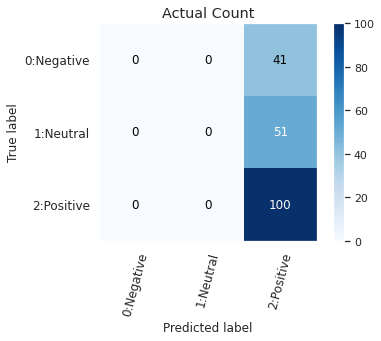

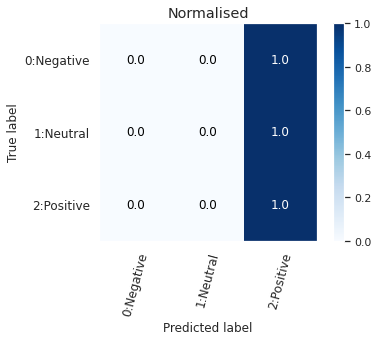

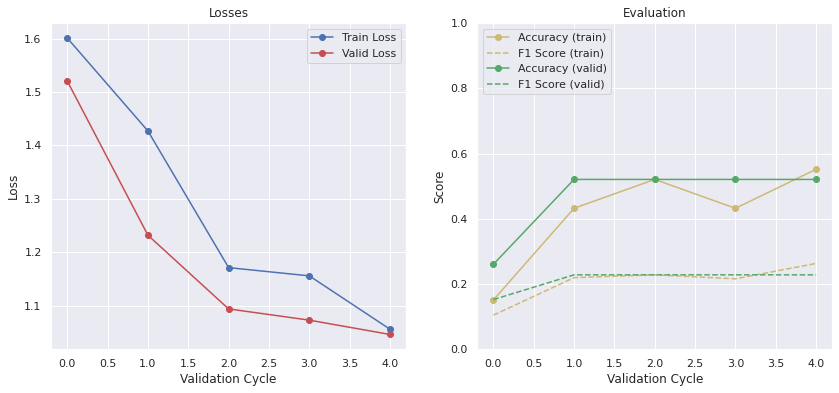

[2020-11-12 23:09:35,413][INFO] ## ================     epoch 2     ===============
[2020-11-12 23:09:35,829][DEBUG] ## Epoch: 2/3, Step: 16, Loss: 3.2134, Acc: 0.5208, F1: 0.2283
[2020-11-12 23:09:36,415][DEBUG] ## Epoch: 2/3, Step: 18, Loss: 3.1982, Acc: 0.5208, F1: 0.2283
[2020-11-12 23:09:37,200][DEBUG] ## Epoch: 2/3, Step: 21, Loss: 3.0742, Acc: 0.5208, F1: 0.2283
[2020-11-12 23:09:37,977][DEBUG] ## Epoch: 2/3, Step: 24, Loss: 3.0621, Acc: 0.5052, F1: 0.2253
[2020-11-12 23:09:38,759][DEBUG] ## Epoch: 2/3, Step: 27, Loss: 2.9392, Acc: 0.5365, F1: 0.3608
[2020-11-12 23:09:39,531][DEBUG] ## Epoch: 2/3, Step: 30, Loss: 2.9086, Acc: 0.5312, F1: 0.2597
[2020-11-12 23:09:39,533][INFO] ## Epoch: 2, Loss: 0.9695, Acc: 0.5312, F1: 0.2597, LR: 8.33e-06


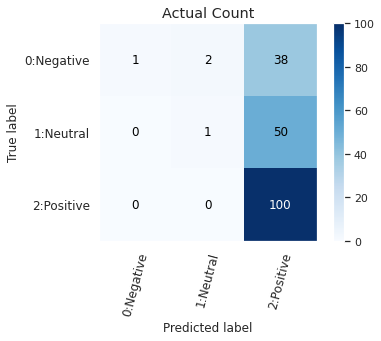

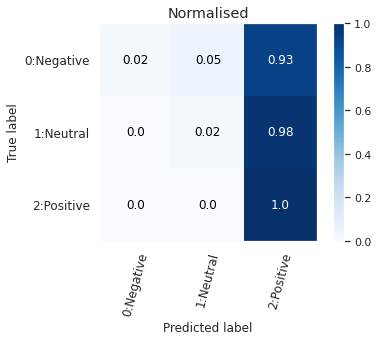

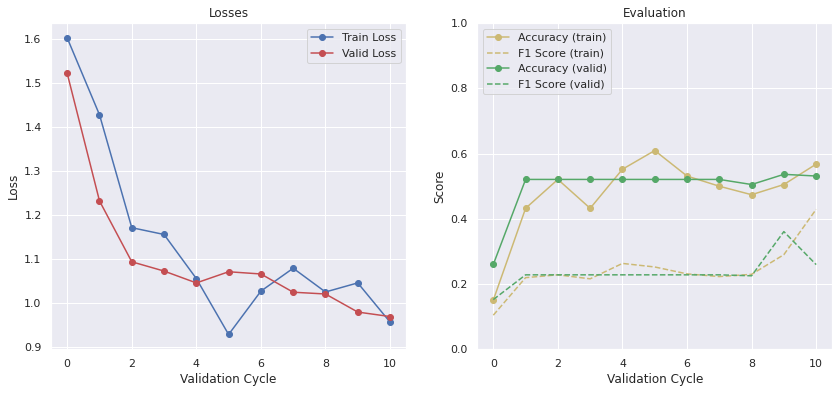

[2020-11-12 23:09:40,813][INFO] ## ================     epoch 3     ===============
[2020-11-12 23:09:41,612][DEBUG] ## Epoch: 3/3, Step: 33, Loss: 2.7928, Acc: 0.5833, F1: 0.4252
[2020-11-12 23:09:42,382][DEBUG] ## Epoch: 3/3, Step: 36, Loss: 2.7592, Acc: 0.5885, F1: 0.5011
[2020-11-12 23:09:43,156][DEBUG] ## Epoch: 3/3, Step: 39, Loss: 2.7643, Acc: 0.6146, F1: 0.4967
[2020-11-12 23:09:43,935][DEBUG] ## Epoch: 3/3, Step: 42, Loss: 2.7434, Acc: 0.6198, F1: 0.5186
[2020-11-12 23:09:44,711][DEBUG] ## Epoch: 3/3, Step: 45, Loss: 2.7263, Acc: 0.5885, F1: 0.5205
[2020-11-12 23:09:44,713][INFO] ## Epoch: 3, Loss: 0.9088, Acc: 0.5885, F1: 0.5205, LR: 1.39e-06


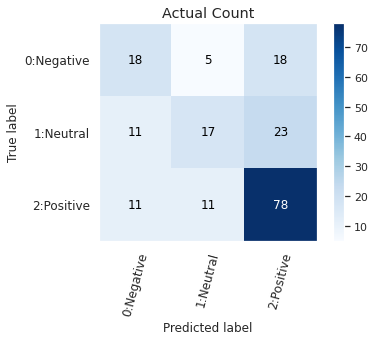

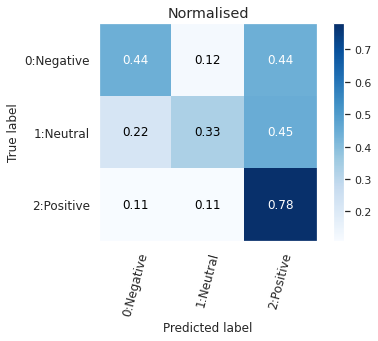

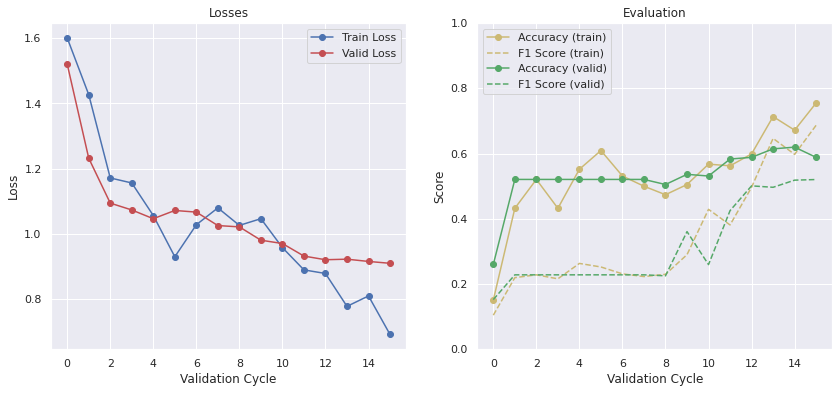


[2020-11-12 23:09:45,607][INFO] ## Process Time (sec): 15.254294168999877

[2020-11-12 23:09:45,609][INFO] ## ############### Start training for 5000 samples ###############


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-11-12 23:10:09,990][INFO] ## Total Training Steps: 237 (79 batches x 3 epochs)


[2020-11-12 23:10:10,174][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-12 23:10:14,038][DEBUG] ## Epoch: 1/3, Step: 15, Loss: 16.3873, Acc: 0.5188, F1: 0.2277
[2020-11-12 23:10:17,867][DEBUG] ## Epoch: 1/3, Step: 30, Loss: 14.2446, Acc: 0.5771, F1: 0.5006
[2020-11-12 23:10:21,699][DEBUG] ## Epoch: 1/3, Step: 45, Loss: 13.3167, Acc: 0.5750, F1: 0.5591
[2020-11-12 23:10:25,545][DEBUG] ## Epoch: 1/3, Step: 60, Loss: 11.2641, Acc: 0.6792, F1: 0.6354
[2020-11-12 23:10:29,385][DEBUG] ## Epoch: 1/3, Step: 75, Loss: 10.3705, Acc: 0.7240, F1: 0.6831
[2020-11-12 23:10:29,943][INFO] ## Epoch: 1, Loss: 0.6914, Acc: 0.7240, F1: 0.6831, LR: 1.49e-05


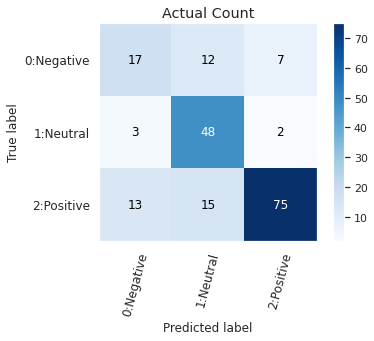

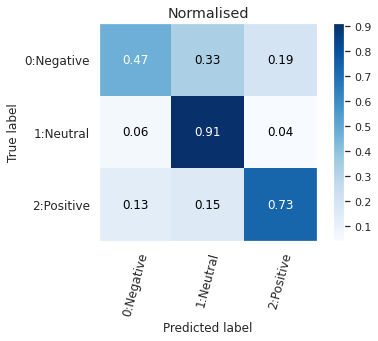

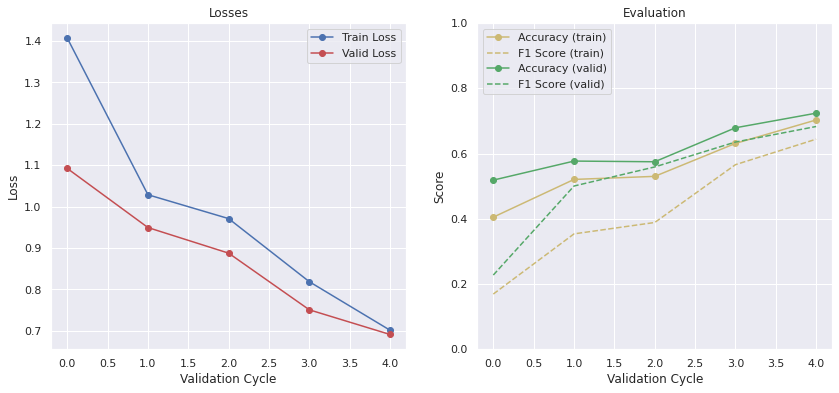

[2020-11-12 23:10:30,859][INFO] ## ================     epoch 2     ===============
[2020-11-12 23:10:32,142][DEBUG] ## Epoch: 2/3, Step: 79, Loss: 10.0860, Acc: 0.7292, F1: 0.6816
[2020-11-12 23:10:35,276][DEBUG] ## Epoch: 2/3, Step: 90, Loss: 10.5102, Acc: 0.7167, F1: 0.6615
[2020-11-12 23:10:39,160][DEBUG] ## Epoch: 2/3, Step: 105, Loss: 9.2605, Acc: 0.7677, F1: 0.7410
[2020-11-12 23:10:43,039][DEBUG] ## Epoch: 2/3, Step: 120, Loss: 9.1302, Acc: 0.7646, F1: 0.7409
[2020-11-12 23:10:46,934][DEBUG] ## Epoch: 2/3, Step: 135, Loss: 8.7812, Acc: 0.7750, F1: 0.7459
[2020-11-12 23:10:50,786][DEBUG] ## Epoch: 2/3, Step: 150, Loss: 8.6756, Acc: 0.7896, F1: 0.7630
[2020-11-12 23:10:51,896][INFO] ## Epoch: 2, Loss: 0.5784, Acc: 0.7896, F1: 0.7630, LR: 7.59e-06


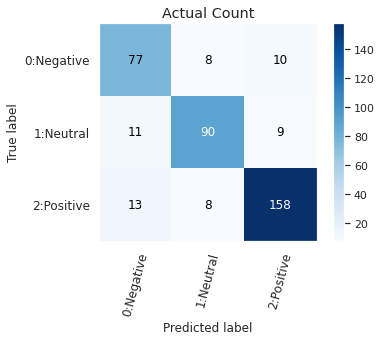

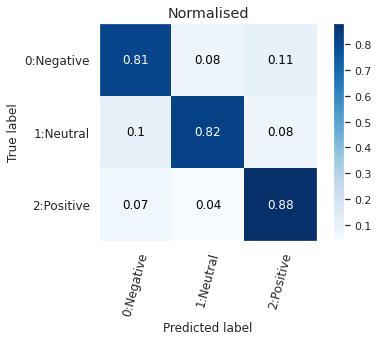

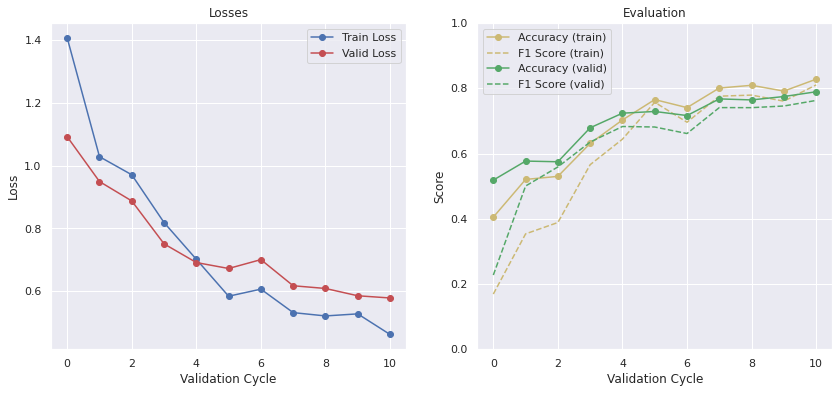

[2020-11-12 23:10:52,774][INFO] ## ================     epoch 3     ===============
[2020-11-12 23:10:55,533][DEBUG] ## Epoch: 3/3, Step: 165, Loss: 8.3970, Acc: 0.7969, F1: 0.7644
[2020-11-12 23:10:59,401][DEBUG] ## Epoch: 3/3, Step: 180, Loss: 8.0741, Acc: 0.8115, F1: 0.7881
[2020-11-12 23:11:03,290][DEBUG] ## Epoch: 3/3, Step: 195, Loss: 8.2797, Acc: 0.8021, F1: 0.7762
[2020-11-12 23:11:07,159][DEBUG] ## Epoch: 3/3, Step: 210, Loss: 8.2297, Acc: 0.8094, F1: 0.7857
[2020-11-12 23:11:11,026][DEBUG] ## Epoch: 3/3, Step: 225, Loss: 8.4275, Acc: 0.7979, F1: 0.7716
[2020-11-12 23:11:12,690][INFO] ## Epoch: 3, Loss: 0.5618, Acc: 0.7979, F1: 0.7716, LR: 2.81e-07


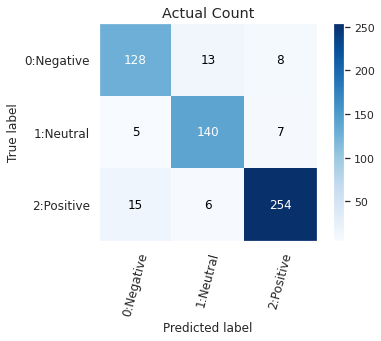

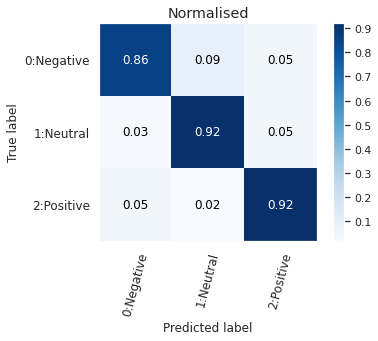

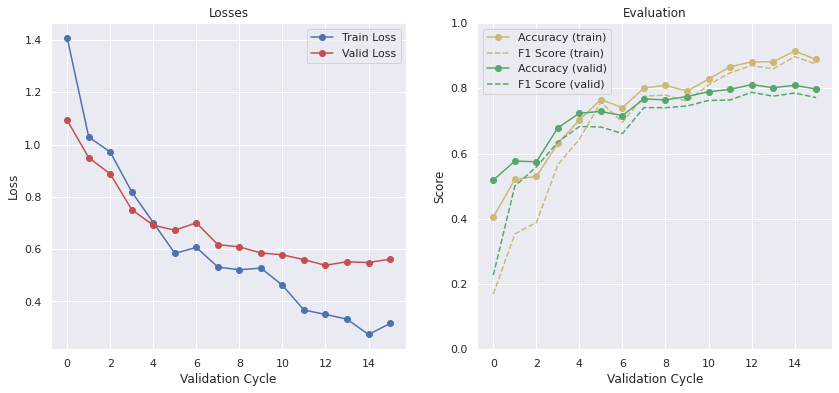


[2020-11-12 23:11:13,595][INFO] ## Process Time (sec): 63.605396796999685

[2020-11-12 23:11:13,597][INFO] ## ############### Start training for 10000 samples ###############


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-11-12 23:11:38,001][INFO] ## Total Training Steps: 471 (157 batches x 3 epochs)


[2020-11-12 23:11:38,187][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-12 23:11:46,244][DEBUG] ## Epoch: 1/3, Step: 31, Loss: 32.2211, Acc: 0.5156, F1: 0.2268
[2020-11-12 23:11:54,266][DEBUG] ## Epoch: 1/3, Step: 62, Loss: 25.8890, Acc: 0.6467, F1: 0.5750
[2020-11-12 23:12:02,232][DEBUG] ## Epoch: 1/3, Step: 93, Loss: 20.0555, Acc: 0.7404, F1: 0.7044
[2020-11-12 23:12:10,226][DEBUG] ## Epoch: 1/3, Step: 124, Loss: 17.2288, Acc: 0.7858, F1: 0.7547
[2020-11-12 23:12:18,212][DEBUG] ## Epoch: 1/3, Step: 155, Loss: 15.6186, Acc: 0.8105, F1: 0.7864
[2020-11-12 23:12:18,405][INFO] ## Epoch: 1, Loss: 0.5038, Acc: 0.8105, F1: 0.7864, LR: 1.49e-05


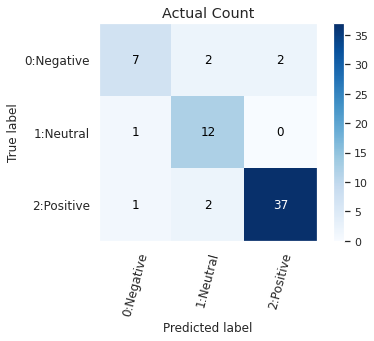

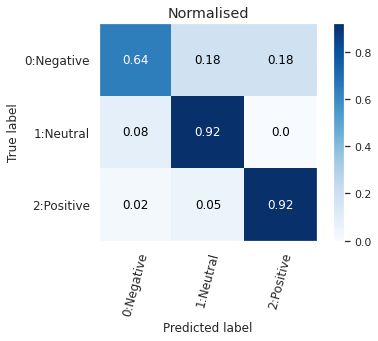

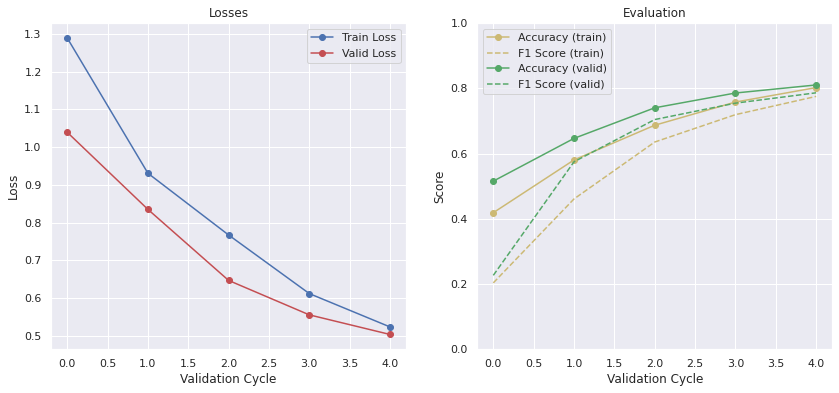

[2020-11-12 23:12:19,364][INFO] ## ================     epoch 2     ===============
[2020-11-12 23:12:21,780][DEBUG] ## Epoch: 2/3, Step: 157, Loss: 15.6313, Acc: 0.8095, F1: 0.7837
[2020-11-12 23:12:29,464][DEBUG] ## Epoch: 2/3, Step: 186, Loss: 14.8325, Acc: 0.8170, F1: 0.7982
[2020-11-12 23:12:37,473][DEBUG] ## Epoch: 2/3, Step: 217, Loss: 15.3369, Acc: 0.8196, F1: 0.7988
[2020-11-12 23:12:45,482][DEBUG] ## Epoch: 2/3, Step: 248, Loss: 14.3973, Acc: 0.8251, F1: 0.8081
[2020-11-12 23:12:53,436][DEBUG] ## Epoch: 2/3, Step: 279, Loss: 13.9788, Acc: 0.8377, F1: 0.8214
[2020-11-12 23:13:01,387][DEBUG] ## Epoch: 2/3, Step: 310, Loss: 13.6194, Acc: 0.8372, F1: 0.8194
[2020-11-12 23:13:01,756][INFO] ## Epoch: 2, Loss: 0.4393, Acc: 0.8372, F1: 0.8194, LR: 7.50e-06


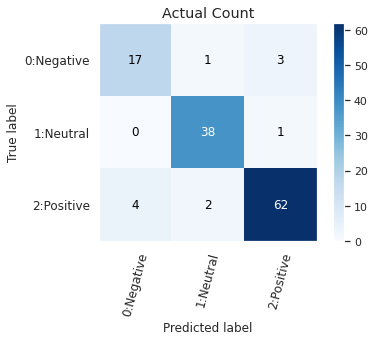

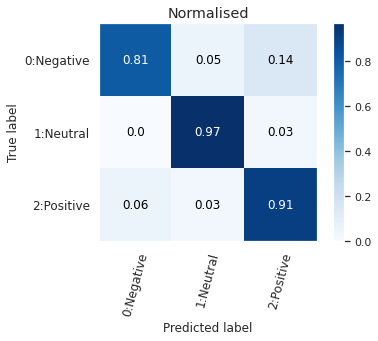

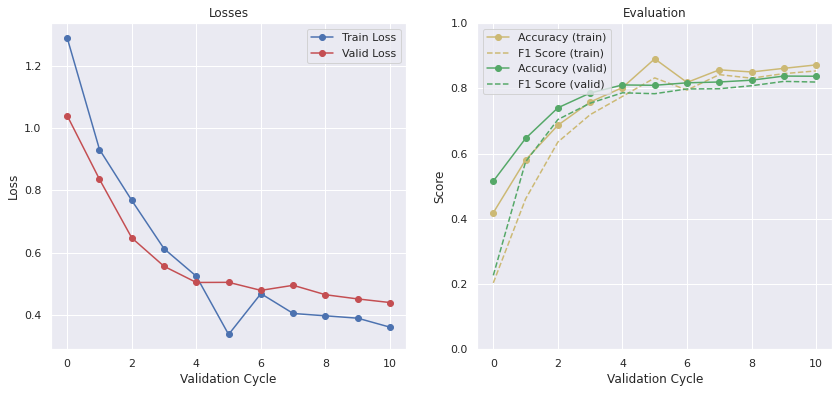

[2020-11-12 23:13:02,639][INFO] ## ================     epoch 3     ===============
[2020-11-12 23:13:10,294][DEBUG] ## Epoch: 3/3, Step: 341, Loss: 14.3559, Acc: 0.8463, F1: 0.8297
[2020-11-12 23:13:18,301][DEBUG] ## Epoch: 3/3, Step: 372, Loss: 13.8051, Acc: 0.8372, F1: 0.8221
[2020-11-12 23:13:26,405][DEBUG] ## Epoch: 3/3, Step: 403, Loss: 14.0063, Acc: 0.8387, F1: 0.8222
[2020-11-12 23:13:34,456][DEBUG] ## Epoch: 3/3, Step: 434, Loss: 14.2199, Acc: 0.8438, F1: 0.8274
[2020-11-12 23:13:42,484][DEBUG] ## Epoch: 3/3, Step: 465, Loss: 14.1247, Acc: 0.8448, F1: 0.8286
[2020-11-12 23:13:43,046][INFO] ## Epoch: 3, Loss: 0.4556, Acc: 0.8448, F1: 0.8286, LR: 1.42e-07


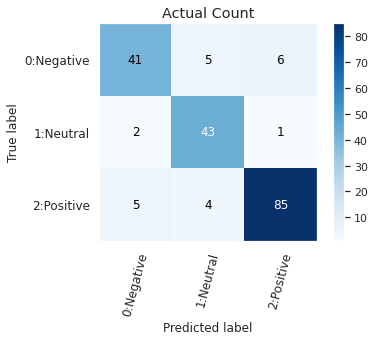

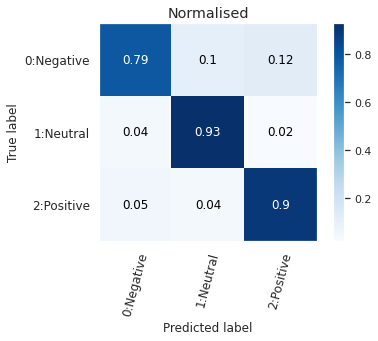

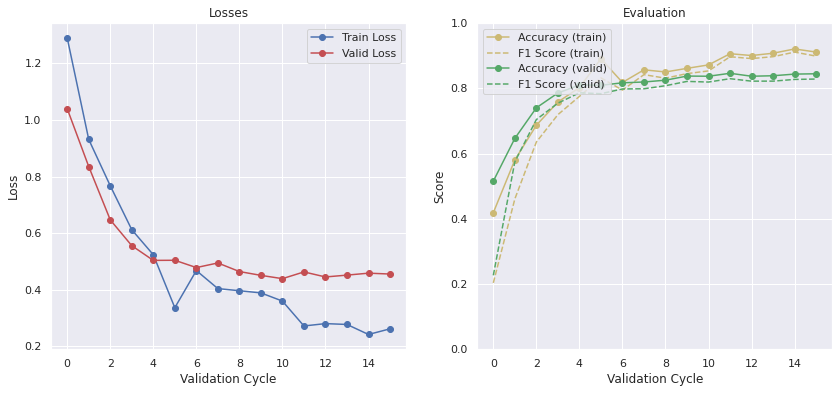


[2020-11-12 23:13:43,934][INFO] ## Process Time (sec): 125.93229375600004

[2020-11-12 23:13:43,939][INFO] ## ############### Start training for 50000 samples ###############


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-11-12 23:14:08,328][INFO] ## Total Training Steps: 2346 (782 batches x 3 epochs)


[2020-11-12 23:14:08,514][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-12 23:14:48,638][DEBUG] ## Epoch: 1/3, Step: 156, Loss: 105.5982, Acc: 0.7179, F1: 0.6929
[2020-11-12 23:15:28,755][DEBUG] ## Epoch: 1/3, Step: 312, Loss: 73.4444, Acc: 0.8328, F1: 0.8121
[2020-11-12 23:16:08,965][DEBUG] ## Epoch: 1/3, Step: 468, Loss: 62.6790, Acc: 0.8525, F1: 0.8316
[2020-11-12 23:16:49,089][DEBUG] ## Epoch: 1/3, Step: 624, Loss: 55.4980, Acc: 0.8673, F1: 0.8526
[2020-11-12 23:17:29,168][DEBUG] ## Epoch: 1/3, Step: 780, Loss: 51.8057, Acc: 0.8758, F1: 0.8625
[2020-11-12 23:17:29,363][INFO] ## Epoch: 1, Loss: 0.3321, Acc: 0.8758, F1: 0.8625, LR: 1.48e-05


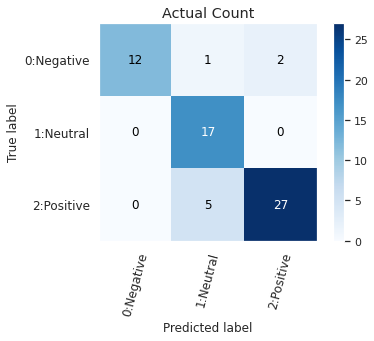

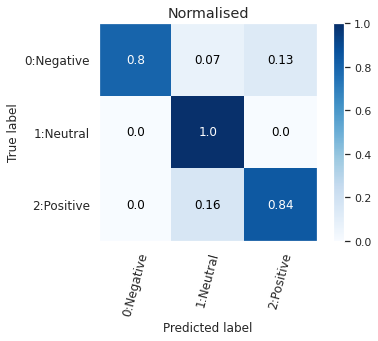

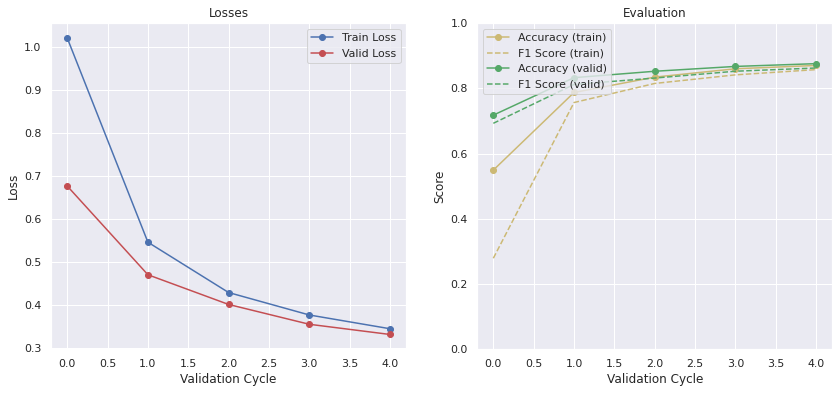

[2020-11-12 23:17:30,288][INFO] ## ================     epoch 2     ===============
[2020-11-12 23:17:41,759][DEBUG] ## Epoch: 2/3, Step: 782, Loss: 51.8105, Acc: 0.8756, F1: 0.8623
[2020-11-12 23:18:21,716][DEBUG] ## Epoch: 2/3, Step: 936, Loss: 50.6441, Acc: 0.8812, F1: 0.8673
[2020-11-12 23:19:01,753][DEBUG] ## Epoch: 2/3, Step: 1092, Loss: 48.5170, Acc: 0.8839, F1: 0.8713
[2020-11-12 23:19:41,825][DEBUG] ## Epoch: 2/3, Step: 1248, Loss: 50.0344, Acc: 0.8837, F1: 0.8700
[2020-11-12 23:20:22,192][DEBUG] ## Epoch: 2/3, Step: 1404, Loss: 47.5939, Acc: 0.8856, F1: 0.8732
[2020-11-12 23:21:02,547][DEBUG] ## Epoch: 2/3, Step: 1560, Loss: 46.9741, Acc: 0.8877, F1: 0.8763
[2020-11-12 23:21:02,933][INFO] ## Epoch: 2, Loss: 0.3011, Acc: 0.8877, F1: 0.8763, LR: 7.43e-06


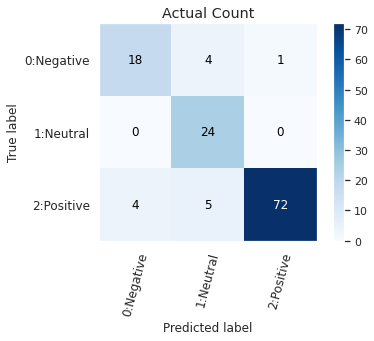

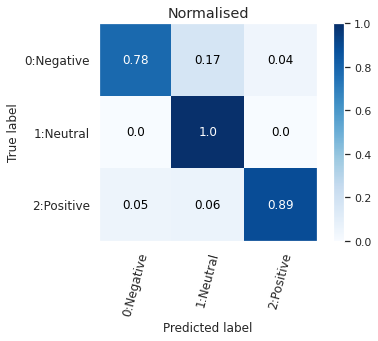

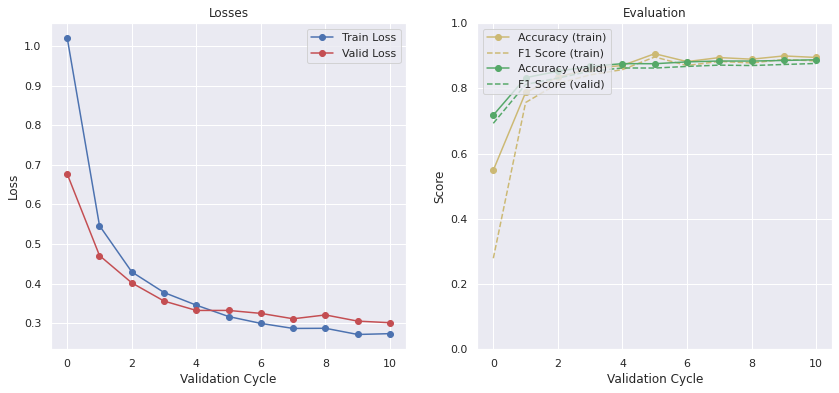

[2020-11-12 23:21:03,834][INFO] ## ================     epoch 3     ===============
[2020-11-12 23:21:43,926][DEBUG] ## Epoch: 3/3, Step: 1716, Loss: 49.0568, Acc: 0.8827, F1: 0.8712
[2020-11-12 23:22:24,049][DEBUG] ## Epoch: 3/3, Step: 1872, Loss: 49.5114, Acc: 0.8825, F1: 0.8695
[2020-11-12 23:23:04,322][DEBUG] ## Epoch: 3/3, Step: 2028, Loss: 51.3252, Acc: 0.8891, F1: 0.8766
[2020-11-12 23:23:44,718][DEBUG] ## Epoch: 3/3, Step: 2184, Loss: 49.1656, Acc: 0.8880, F1: 0.8759
[2020-11-12 23:24:25,051][DEBUG] ## Epoch: 3/3, Step: 2340, Loss: 49.1658, Acc: 0.8869, F1: 0.8748
[2020-11-12 23:24:25,618][INFO] ## Epoch: 3, Loss: 0.3152, Acc: 0.8869, F1: 0.8748, LR: 2.84e-08


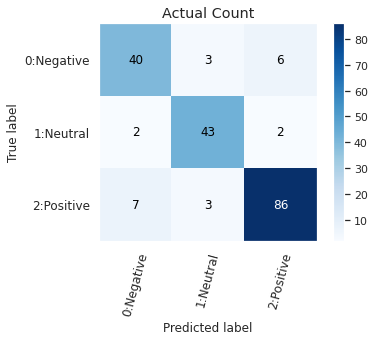

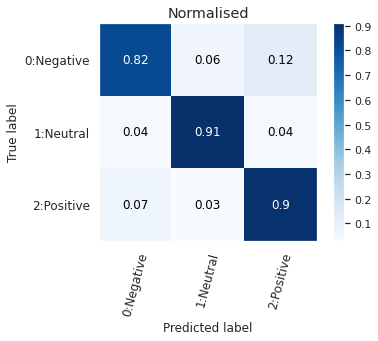

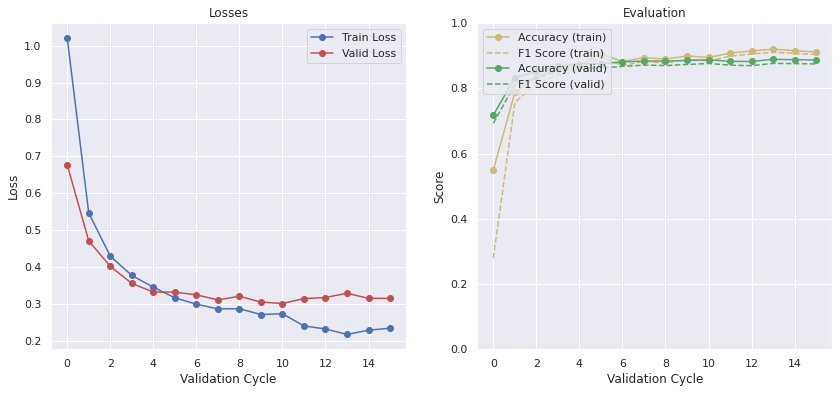


[2020-11-12 23:24:26,550][INFO] ## Process Time (sec): 618.2218343230002


,Accuracy,F1(macro),Total_Time,ms/text
1000,0.5885,0.5205,15.2543,15.2543
5000,0.7979,0.7716,63.6054,12.7211
10000,0.8448,0.8286,125.932,12.5932
50000,0.8869,0.8748,618.222,12.3644


In [ ]:
# Define the training parameters
num_samples = [1000, 5000, 10000, 50000]
epochs=3
patience=3
batch_size=64
seq_len = 30
lr=2e-5
clip=1.0
log_level=logging.DEBUG

# Run!
result_bert, model_trained_bert = train_cycles(train_df['text'], train_df['label'], vocab, num_samples, 'BERT', epochs, patience, batch_size, seq_len, lr, clip, log_level)
result_bert

# BERT model metrics comparison
## reconstruct accuracy,F1,training time results based on above training results when the notebook get disconnected

In [2]:
#reconstruct the bert result dataframe. If the notebook didn't get disconnected, don't need to run this cell. 
# If you decide to use this cell, make sure to check the metric scores match the training result.
n_trains = [1000, 5000, 10000, 50000]
result_bert = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time'], index=n_trains)
result_bert.loc[1000] = (0.5885,0.5205,15.2543)
result_bert.loc[5000] = (0.7979,0.7716,63.6054)
result_bert.loc[10000] = (0.8448,0.8286,125.932)
result_bert.loc[50000] = (0.8869,0.8748,618.222)
result_bert['ms/data'] = result_bert['Total_Time'] / result_bert.index * 1000
result_bert

,Accuracy,F1(macro),Total_Time,ms/data
1000,0.5885,0.5205,15.2543,15.2543
5000,0.7979,0.7716,63.6054,12.7211
10000,0.8448,0.8286,125.932,12.5932
50000,0.8869,0.8748,618.222,12.3644


# Plot results
Accuray, F1, Total training time and time per sample

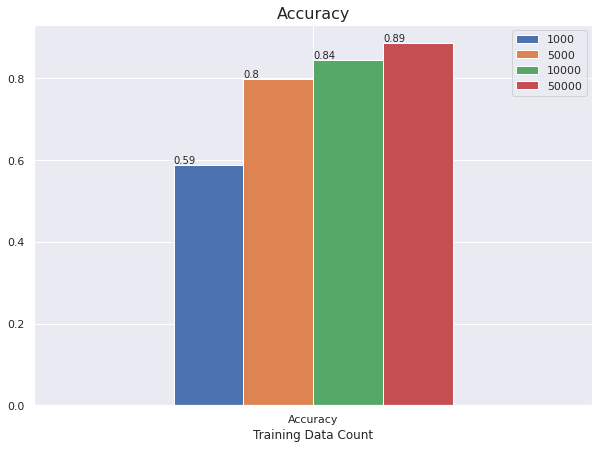

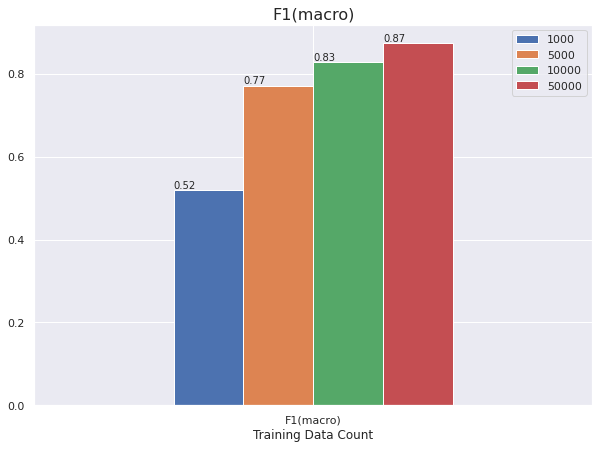

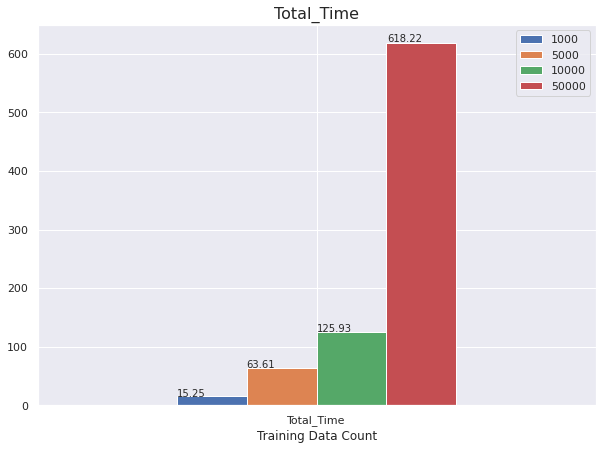

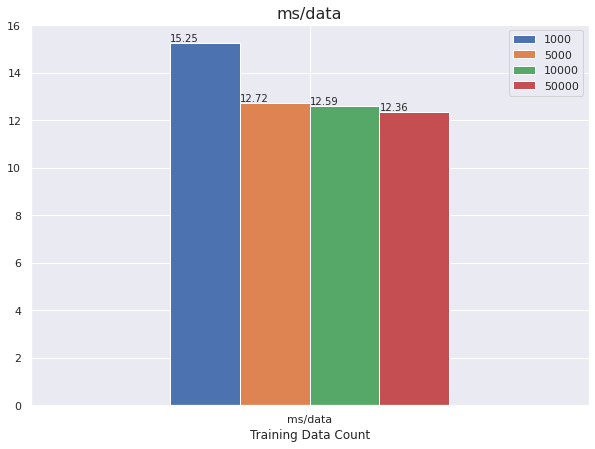

In [3]:
def plot_result(column):
    result_accuracy = pd.DataFrame(data=result_bert[column]).T
    ax = result_accuracy.plot.bar(rot=0, figsize=(10,7))
    ax.set_title(column, fontsize=16)
    ax.set_xlabel('Training Data Count')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

plot_result('Accuracy')
plot_result('F1(macro)')
plot_result('Total_Time')
plot_result('ms/data')